Importing the required libraries


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import aplpy
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from scipy.optimize import curve_fit
from astropy.stats import bootstrap
plt.rcParams.update({'font.size': 18})

Writing the required functions

In [3]:
def generate_RA_DEC_mesh(hdr):
    """generate_RA_DEC_mesh

    Generates the RA and DEC grid for the intensity map

    """
    if 'CDELT1' in hdr.header:
        RA_delt = hdr.header['CDELT1']
        DEC_delt = hdr.header['CDELT2']

    if 'CD1_1' in hdr.header:
        RA_delt = hdr.header['CD1_1']
        DEC_delt = hdr.header['CD2_2']

    RA_ref = (hdr.header['CRPIX1'])
    DEC_ref = (hdr.header['CRPIX2'])
    RA_ref_value = hdr.header['CRVAL1']
    DEC_ref_value = hdr.header['CRVAL2']
    RA_axis_len = hdr.header['NAXIS1']
    DEC_axis_len = hdr.header['NAXIS2']

    RA_axis = np.arange(1,RA_axis_len+1)
    DEC_axis = np.arange(1,DEC_axis_len+1)
    DEC_axis_modified = np.arange(1,RA_axis_len+1)
    
    DEC_array = (DEC_axis - DEC_axis_len/2)*DEC_delt + DEC_ref_value
    DEC_array_modified = (DEC_axis_modified - RA_axis_len/2)*DEC_delt + DEC_ref_value
    RA_array = RA_ref_value-(RA_axis - RA_axis_len/2)*(RA_delt*(-1)/np.cos(DEC_array_modified*0.01745))

    # #making a meshgrid from the arrays
    DEC_grid,RA_grid = np.meshgrid(DEC_array,RA_array , sparse=False, indexing='ij')
    return DEC_grid,RA_grid

def Calc_l(ra1,dec1,ra2,dec2):

    c1 = SkyCoord(ra1,dec1,unit = 'deg')
    c2 = SkyCoord(ra2,dec2,unit = 'deg')
    sep = c1.separation(c2)
    return sep.arcminute
    
def wrapper(Angle_grid):
    while ((np.nanmax(Angle_grid)>90) or (np.nanmin(Angle_grid)<-90)):
        Angle_selector =Angle_grid>90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] - 180
        Angle_selector = Angle_grid<-90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] + 180
    return Angle_grid

Importing the fits files

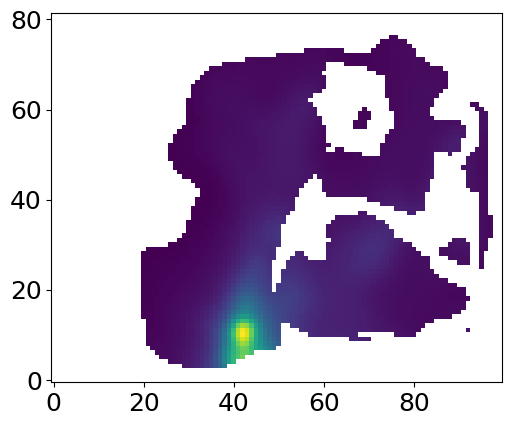

In [4]:
########## importing and testing the file
FITS1 = '../FITS_file/DR21_C2N.fits'
FITS2 = '../FITS_file/Siddharth/DR21_NH2_Repr_C2N.fits'
FITS3 = '../FITS_file/Siddharth/DR21_Tdust_Repr_C2N.fits'
FITS4 = '../FITS_file/Siddharth/DR21_IRAC4_Repr_C2N.fits'
FITS5 = '../FITS_file/Siddharth/DR21_Her250_Repr_C2N.fits'
hdul = fits.open(FITS1)
hdul2 = fits.open(FITS2)
hdul3 = fits.open(FITS3)
hdul4 = fits.open(FITS4)
hdul5 = fits.open(FITS5)



MapStokesI = hdul[0]
MapStokesIError = hdul[1]
MapStokesQ = hdul[2]
MapStokesU = hdul[4]
MapDebPol = hdul[8]
MapDebPolError = hdul[9]
MapPolAngleNonRotated = hdul[10]
MapPolAngle = hdul[11]
MapPolAngleError = hdul[12]
MapPolFlux = hdul[13]
MapPolFluxError = hdul[14]
MapColumndensity = hdul2[0]
MapTemperature = hdul3[0]
Map8Micron = hdul4[0]
MapHer250 = hdul5[0]



MapPolSNR = MapDebPol.copy()
BlankedMapPol = MapDebPol.copy()
BlankedMapPolAngle = MapPolAngle.copy()
BlankedMapPolAngleError = MapPolAngleError.copy()
BlankedMapPolAngleNonRotated = MapPolAngleNonRotated.copy() 
BlankedMapStokesI = MapStokesI.copy()
BlankedMapStokesQ = MapStokesQ.copy()
BlankedMapStokesU = MapStokesU.copy()
BlankedMapColumnDensity = MapColumndensity.copy()
BlankedMapTemperature = MapTemperature.copy()
BlankedMap8Mircon = Map8Micron.copy()
BlankedMapHer250 = MapHer250.copy()



######## taking points only with singal to noise ratio more than 3
MapPolSNR.data[:] = np.nan
MapPolSNR.data = MapDebPol.data/MapDebPolError.data


Selector = (MapPolSNR.data < 3)
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan



############## removing any points with pfrac above 50
Selector = (BlankedMapPol.data>50)
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan


############# removing any data points with I/I_error < 100
Selector = MapStokesI.data/MapStokesIError.data < 100
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan


BlankedMapColumnDensity.data = BlankedMapColumnDensity.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapTemperature.data = BlankedMapTemperature.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMap8Mircon.data = BlankedMap8Mircon.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapPolAngleError.data = BlankedMapPolAngleError.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapHer250.data = BlankedMapHer250.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)



############## generating the RA and DEC mesh
DEC_grid,RA_grid = generate_RA_DEC_mesh(hdul[0])
seperation = MapPolAngle.copy()

plt.figure()
plt.imshow(BlankedMapStokesI.data,origin='lower')
plt.show()



In [5]:

set_delta = 0.5   # in arcminute
S_map = BlankedMapPolAngle.copy()
sigma_S_map = BlankedMapPolAngleError.copy()

for i in range(RA_grid.shape[0]):
    for j in range(RA_grid.shape[1]):

        ##### seperation filter
        seperation.data = Calc_l(RA_grid[i,j],DEC_grid[i,j],RA_grid,DEC_grid)
        seperation_selector = (seperation.data<0.5*set_delta)
        seperation.data[seperation_selector] = np.nan
        seperation_selector = (seperation.data>1.5*set_delta)
        seperation.data[seperation_selector] = np.nan
        seperation_selector = (seperation.data >0)

        ##### making the dispersion map
        tempa = BlankedMapStokesQ.data*BlankedMapStokesU.data[i,j] - BlankedMapStokesQ.data[i,j]*BlankedMapStokesU.data
        tempb = BlankedMapStokesQ.data*BlankedMapStokesQ.data[i,j] + BlankedMapStokesU.data*BlankedMapStokesU.data[i,j]
        AngleDiff_v2 = 0.5 * (180/np.pi)*np.arctan2(tempa,tempb)
        S = np.nanmean(AngleDiff_v2[seperation_selector]**2)**0.5
        S_map.data[i,j] = S

        ##### making the dispersion error map
        sigma_S = np.nanmean(BlankedMapPolAngleError.data[seperation_selector]**2)**0.5
        sigma_S_map.data[i,j] = sigma_S



C:\Users\DELL\AppData\Local\Temp\ipykernel_2284\2043383840.py:20: RuntimeWarning: Mean of empty slice
  S = np.nanmean(AngleDiff_v2[seperation_selector]**2)**0.5
C:\Users\DELL\AppData\Local\Temp\ipykernel_2284\2043383840.py:24: RuntimeWarning: Mean of empty slice
  sigma_S = np.nanmean(BlankedMapPolAngleError.data[seperation_selector]**2)**0.5


Debiasing the dispersion map

C:\Users\DELL\AppData\Local\Temp\ipykernel_2284\1630940181.py:2: RuntimeWarning: invalid value encountered in sqrt
  S_map_deb.data = np.sqrt(S_map.data**2 - sigma_S_map.data**2)


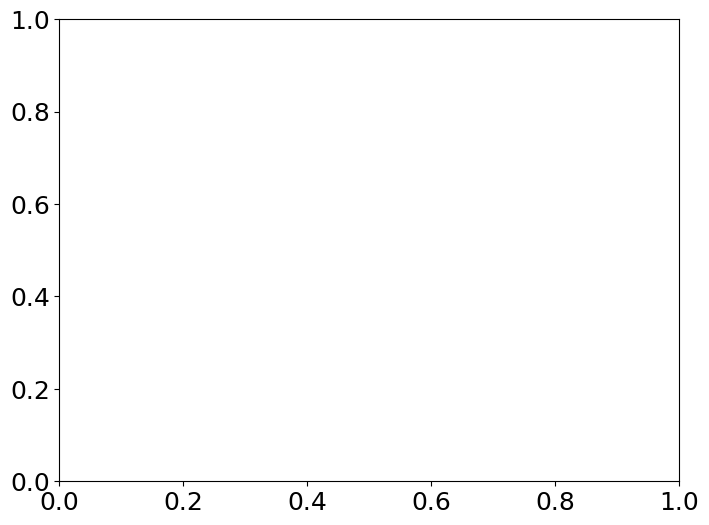

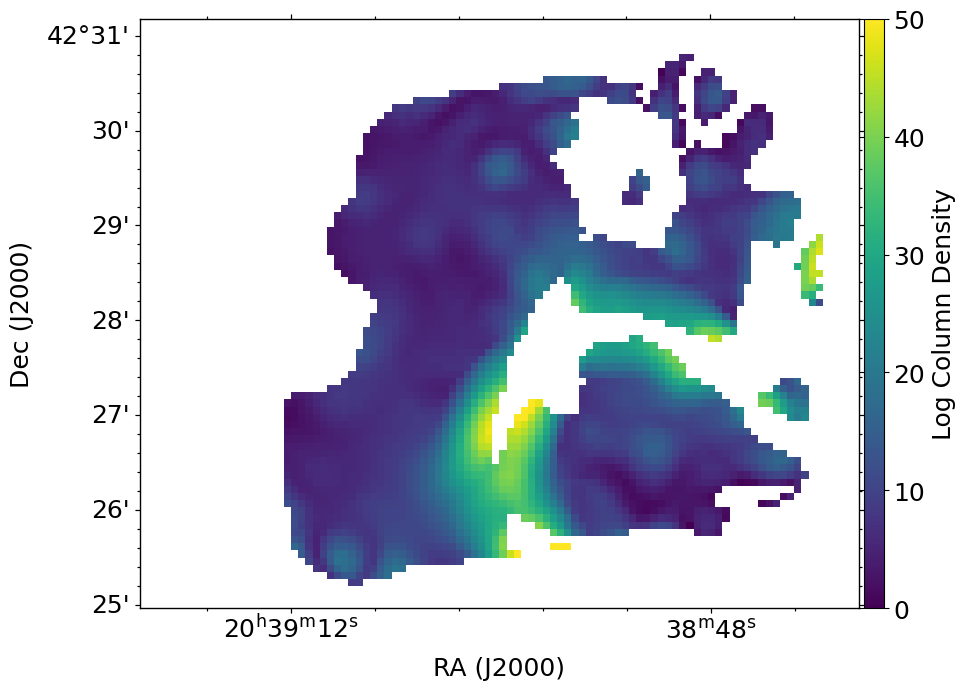

In [8]:
S_map_deb = S_map.copy()
S_map_deb.data = np.sqrt(S_map.data**2 - sigma_S_map.data**2)

# plt.figure(figsize=(14,10))
# plt.imshow(S_map_deb.data,origin='lower', extent=[np.nanmax(RA_grid),np.nanmin(RA_grid),np.nanmin(DEC_grid),np.nanmax(DEC_grid)])
# plt.show()

LogMapColumnDensity = MapColumndensity.copy()
LogMapColumnDensity.data = np.log10(LogMapColumnDensity.data)



fig = plt.subplots(figsize =(8, 6))
scuba = aplpy.FITSFigure(S_map_deb)
scuba.ticks.set_xspacing(0.1) # number in degrees

scuba.show_colorscale(cmap='default',vmin = 0,vmax = 50)

scuba.ticks.show()
scuba.ticks.show_x()
scuba.ticks.show_y()
# aplpy.Colorbar.show(location='right', width=0.2, pad=0.05, ticks=None,)
scuba.add_colorbar(location='right', width=0.2, pad=0.05, ticks=None,axis_label_text= 'Log Column Density')
plt.tight_layout()
plt.show()

Plotting the relations between p, nh2 and s 

Fitting the curves to individual relations between p vs I, s and NH2

Fitting the double parameter function log p  = C + alpha_s log s + alpha_I log I and log p  = C + alpha_s log s + alpha_NH2 log NH2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


C : 16.349296948283147
s index : -0.4268426725622027
nh2 index : -0.6819278463229592


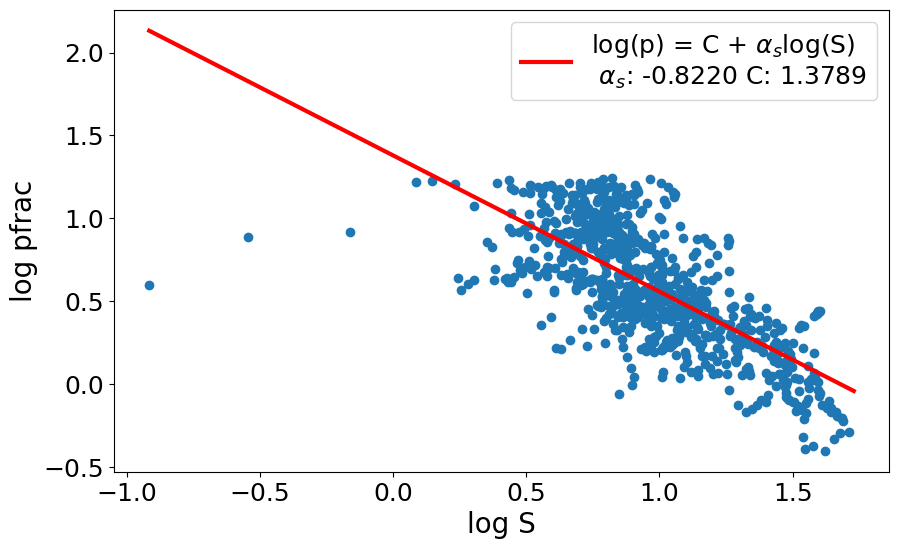

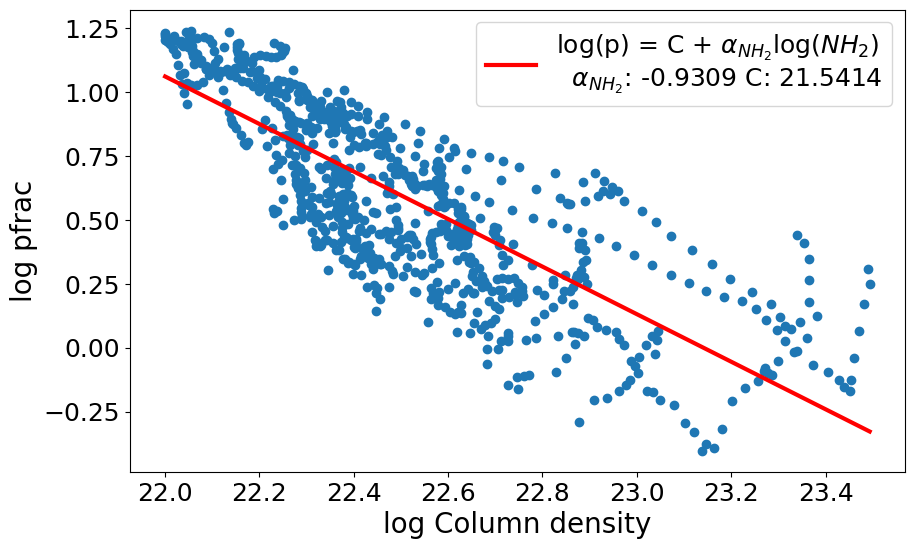

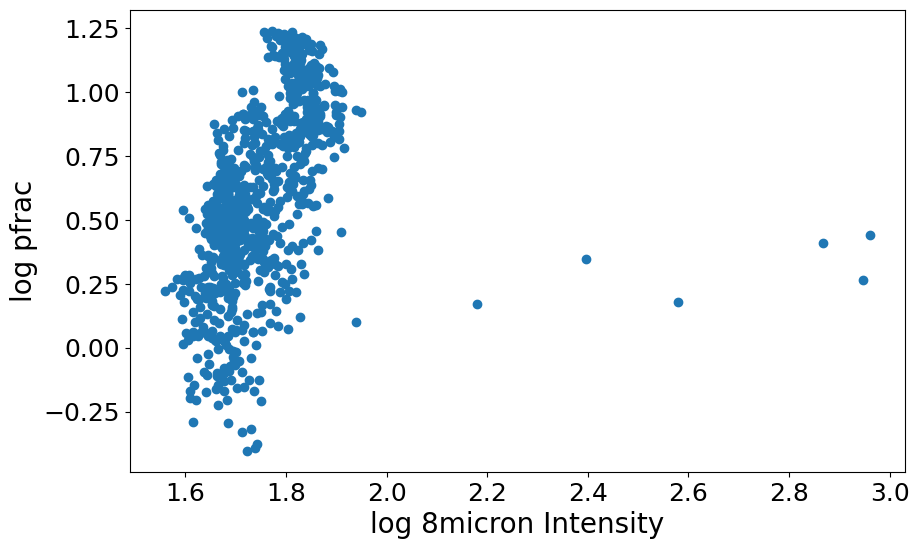

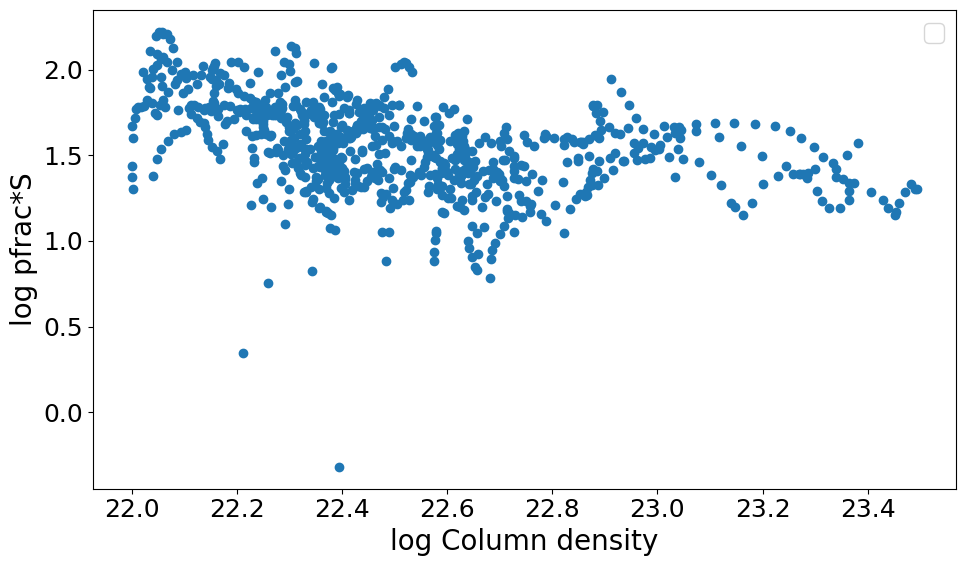

In [10]:
def lin_fit(x, a, b):
    return a + b*x

def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y



############### changing data to array
s_array = S_map_deb.data.flatten()
p_array = BlankedMapPol.data.flatten()
I_array = BlankedMapStokesI.data.flatten()
nh2_array = BlankedMapColumnDensity.data.flatten()
micron8_array = BlankedMap8Mircon.data.flatten()


############# making the data independent
s_array_ind = s_array.copy()
s_array_ind = s_array_ind[::4]
p_array_ind = p_array.copy()
p_array_ind = p_array_ind[::4]
I_array_ind = I_array.copy()
I_array_ind = I_array_ind[::4]
nh2_array_ind = nh2_array.copy()
nh2_array_ind = nh2_array_ind[::4]
micron8_array_ind = micron8_array.copy()
micron8_array_ind = micron8_array_ind[::4]


########## taking log 10 of the data
log_s = np.log10(s_array_ind)
log_p = np.log10(p_array_ind)
log_I = np.log10(I_array_ind)
log_nh2 = np.log10(nh2_array_ind)
log_8micron = np.log10(micron8_array_ind)

######## making bins of the array for curve fitting
p_min = np.nanmin(log_p)
p_max = np.nanmax(log_p)
s_min = np.nanmin(log_s)
s_max = np.nanmax(log_s)
I_min = np.nanmin(log_I)
I_max = np.nanmax(log_I)
nh2_min = np.nanmin(log_nh2)
nh2_max = np.nanmax(log_nh2)
micron8_min = np.nanmin(log_8micron)
micron8_max = np.nanmax(log_8micron)  

p_bins = np.linspace(p_min, p_max, 100)
s_bins = np.linspace(s_min, s_max, 100)
I_bins = np.linspace(I_min, I_max, 100)
nh2_bins = np.linspace(nh2_min,nh2_max, 100)
micron8_bins = np.linspace(micron8_min,micron8_max,100)

############ fitting the data 
df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'logI':log_I,'lognh2':log_nh2,'log_8micron':log_8micron})
df_log = df_log.dropna()

########### single parameter fitting
PS_param, PS_param_cov = curve_fit(lin_fit, df_log['logs'], df_log['logp'])
PS_FitFunc = lin_fit(s_bins,PS_param[0],PS_param[1])

PI_param, PI_param_cov = curve_fit(lin_fit, df_log['logI'], df_log['logp'])
PI_FitFunc = lin_fit(I_bins,PI_param[0],PI_param[1])

Pnh2_param, Pnh2_param_cov = curve_fit(lin_fit, df_log['lognh2'], df_log['logp'])
Pnh2_FitFunc = lin_fit(nh2_bins,Pnh2_param[0],Pnh2_param[1])

########### Double parameter fitting
# p0 = -0.2278,-0.3994,2.
# PSI_param_lower, PSI_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['logI']), df_log['logp'],p0)
# print('C :',PSI_param_lower[0])
# print('s index :',PSI_param_lower[1])
# print('I index :',PSI_param_lower[2])

p0 = -0.2278, -0.8567, 2.
PSNH2_param_lower, PSNH2_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['lognh2']), df_log['logp'],p0)
print('C :',PSNH2_param_lower[0])
print('s index :',PSNH2_param_lower[1])
print('nh2 index :',PSNH2_param_lower[2])



#################### plotting the graphs

fig = plt.subplots(figsize =(10, 6))
ax1 = plt.subplot(111)
ax1.scatter(log_s,log_p)
label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_param[1],C = PS_param[0],linebreak='\n')
ax1.plot(s_bins,PS_FitFunc,'r',linewidth=3,label = label_temp)
# ax1.set_title("whole region Polarization fraction vs S")
ax1.set_ylabel('log pfrac',fontdict={'fontsize':20})
ax1.set_xlabel('log S',fontdict={'fontsize':20})

# fig = plt.subplots(figsize =(12, 8))
# ax2 = plt.subplot(111)
# ax2.scatter(log_I,log_p)
# label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_param[1],C = PI_param[0],linebreak='\n')
# ax2.plot(I_bins,PI_FitFunc,'r',linewidth=3,label = label_temp)
# # ax2.set_title("whole region log p X log I")
# ax2.set_ylabel('log p')
# ax2.set_xlabel('log I')

fig = plt.subplots(figsize =(10, 6))
ax3 = plt.subplot(111)
ax3.scatter(log_nh2,log_p)
label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_param[1],C = Pnh2_param[0],linebreak='\n')
ax3.plot(nh2_bins,Pnh2_FitFunc,'r',linewidth=3,label = label_temp)
# ax3.set_title("whole region log p X log nh2")
ax3.set_ylabel('log pfrac',fontdict={'fontsize':20})
ax3.set_xlabel('log Column density',fontdict={'fontsize':20})


fig = plt.subplots(figsize =(10, 6))
ax4 = plt.subplot(111)
ax4.scatter(log_8micron,log_p)
# label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_param[1],C = Pnh2_param[0],linebreak='\n')
# ax4.set_title("whole region log pfrac vs log 8micron intensity")
ax4.set_ylabel('log pfrac',fontdict={'fontsize':20})
ax4.set_xlabel('log 8micron Intensity',fontdict={'fontsize':20})

fig = plt.subplots(figsize =(10, 6))
ax5 = plt.subplot(111)
ax5.scatter(np.log10(nh2_array_ind),np.log10(p_array_ind*s_array_ind))
# label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_param[1],C = Pnh2_param[0],linebreak='\n')
# ax4.set_title("whole region log pfrac vs log 8micron intensity")
ax5.set_ylabel('log pfrac*S',fontdict={'fontsize':20})
ax5.set_xlabel('log Column density',fontdict={'fontsize':20})


ax1.legend()
ax3.legend()
plt.legend()
plt.tight_layout()
plt.rcParams.update({'font.size': 19})
plt.show()


Bootstrap error estimation of the whole region.

In [35]:
# s_whole_array = S_map_deb.data.flatten()
# p_whole_array = BlankedMapPol.data.flatten()
# nh2_whole_array = BlankedMapColumnDensity.data.flatten()


# # log_s = np.log(s_whole_array)
# # log_p = np.log(p_whole_array)
# # log_nh2 = np.log(nh2_whole_array)

# log_s = np.arange(0,20,0.1) 
# log_s = log_s + np.random.normal(1, 1, log_s.shape)
# log_nh2 = np.arange(20,40,0.1) 
# log_nh2 = log_nh2 + np.random.normal(1, 1, log_s.shape)
# log_p = 10 + (-1)*log_s + log_nh2*(-0.5)


# df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'lognh2':log_nh2})
# df_log = df_log.dropna()

# def DoubleParamFunc(X, a, b, c):
#     x,y = X
#     return a + b*x + c*y

# def curve_fitting(x):
#     param, param_cov = curve_fit(DoubleParamFunc,(x[:,2],x[:,1]),x[:,0])
#     return param
#     return np.sqrt(np.diag(param_cov))


# bootarr = np.array(df_log)


# bootresult = bootstrap(bootarr,10,bootfunc=curve_fitting)
# print(bootresult)
# # print('error in alpha_s',np.std(bootresult[:,1]))
# # print('error in alpha_nh2',np.std(bootresult[:,2]))

# param, param_cov = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['lognh2']),df_log['logp'])
# # param_cov = curve_fitting(bootarr)


[[10.  -0.5 -1. ]
 [10.  -0.5 -1. ]
 [10.  -0.5 -1. ]
 [10.  -0.5 -1. ]
 [10.  -0.5 -1. ]
 [10.  -0.5 -1. ]
 [10.  -0.5 -1. ]
 [10.  -0.5 -1. ]
 [10.  -0.5 -1. ]
 [10.  -0.5 -1. ]]


In [12]:
# DEC_array = DEC_grid.flatten()
# RA_array = RA_grid.flatten()
# StokesI_array = BlankedMapStokesI.data.flatten()
# S_array = S_map_deb.data.flatten()
# P_array = BlankedMapPol.data.flatten()
# nh2_array = BlankedMapColumnDensity.data.flatten()
# temperature_array = BlankedMapTemperature.data.flatten()
# PolAngleNonRotated_array = BlankedMapPolAngleNonRotated.data.flatten()
# micron8_array = BlankedMap8Mircon.data.flatten()

# df = pd.DataFrame({'RA': RA_array, 'DEC': DEC_array,'P':P_array ,'I': StokesI_array,'S':S_array,'ColumnDen':nh2_array,'Temperature':temperature_array,'8micron':micron8_array})
# df.to_csv('data_dr21_C2N.csv',sep=chr(44))

Dividing the whole region into sub-regions

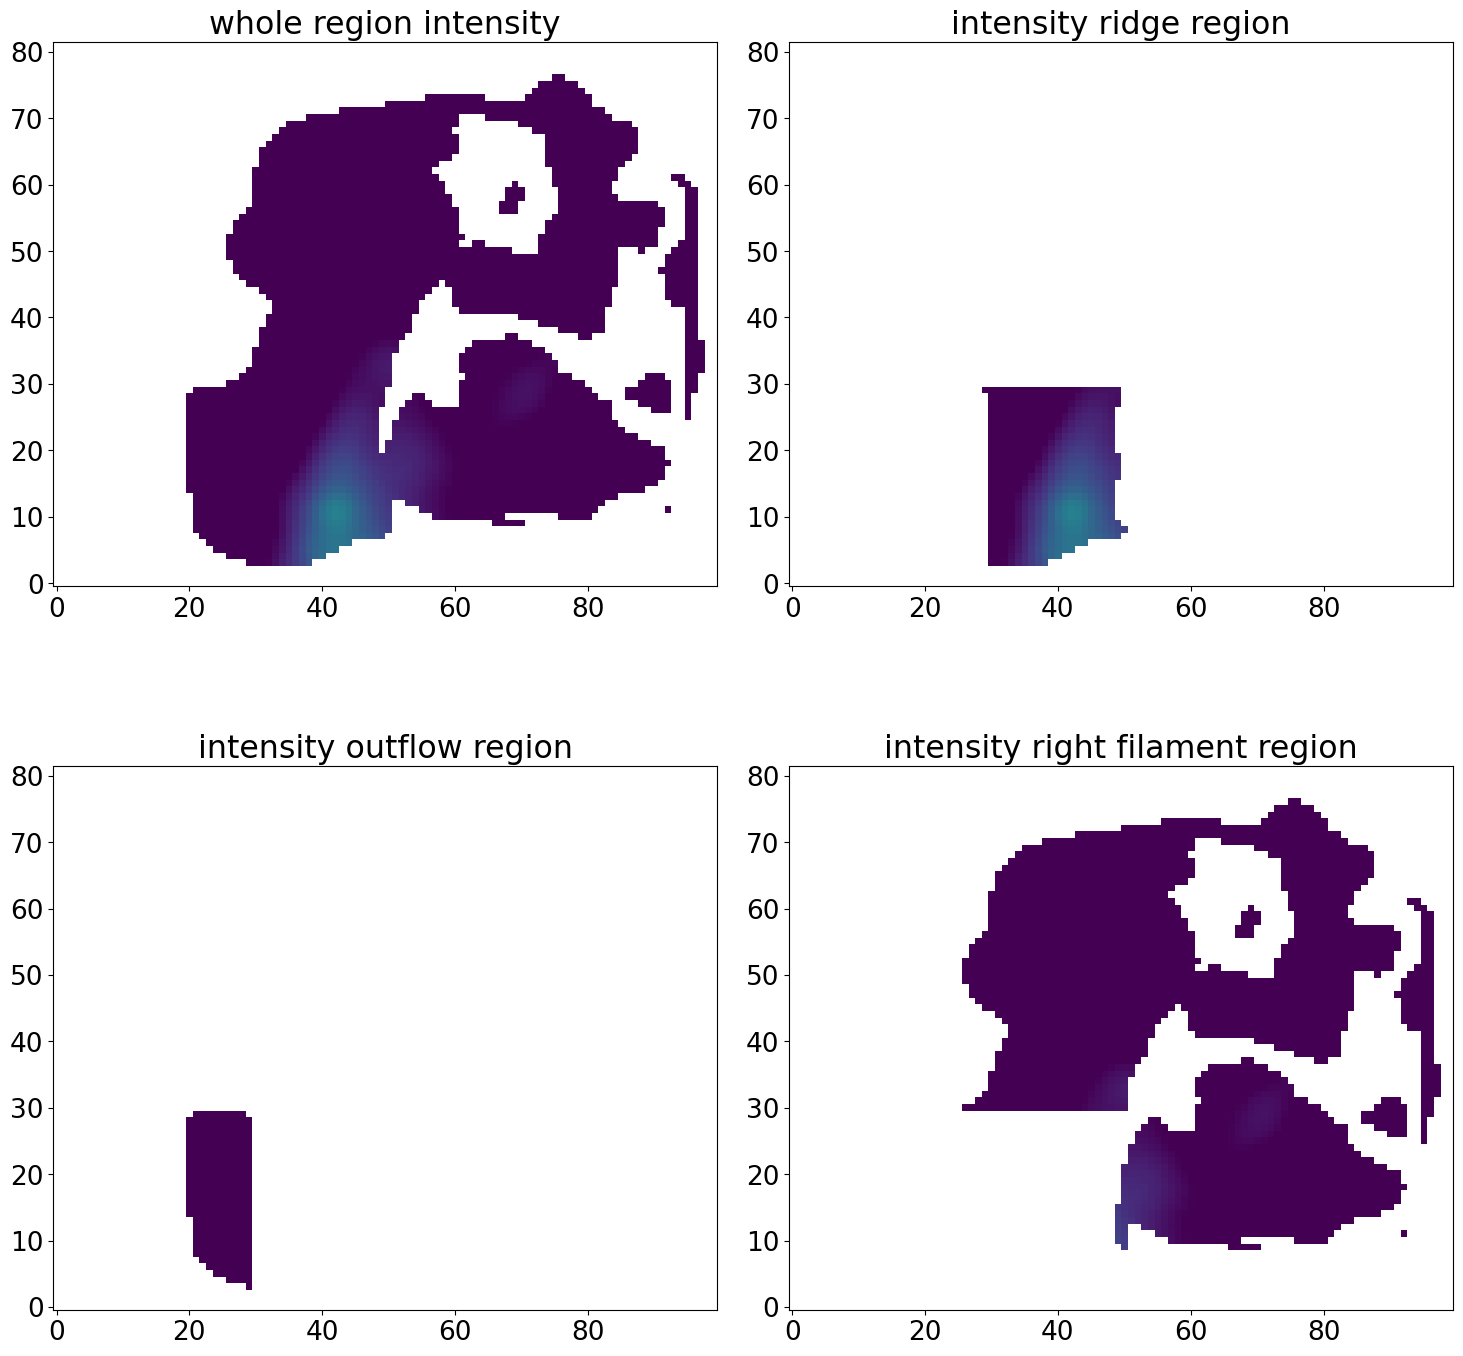

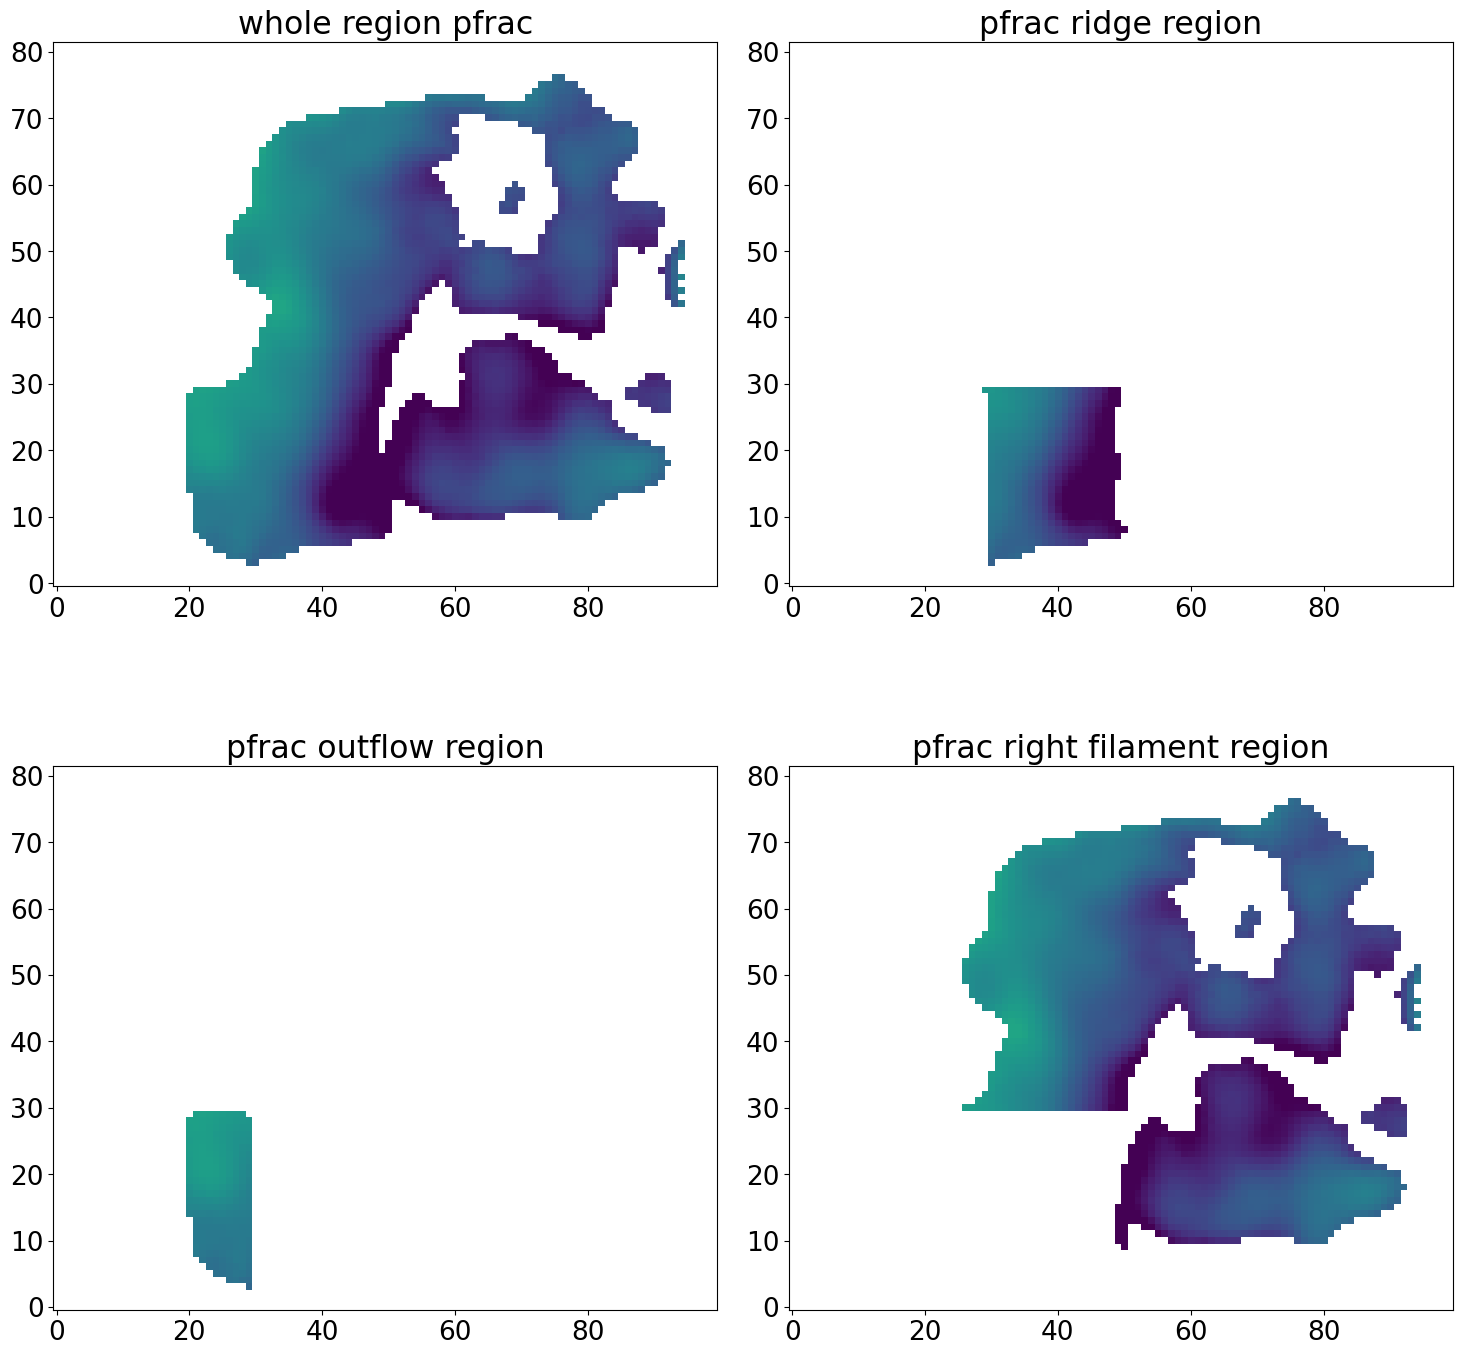

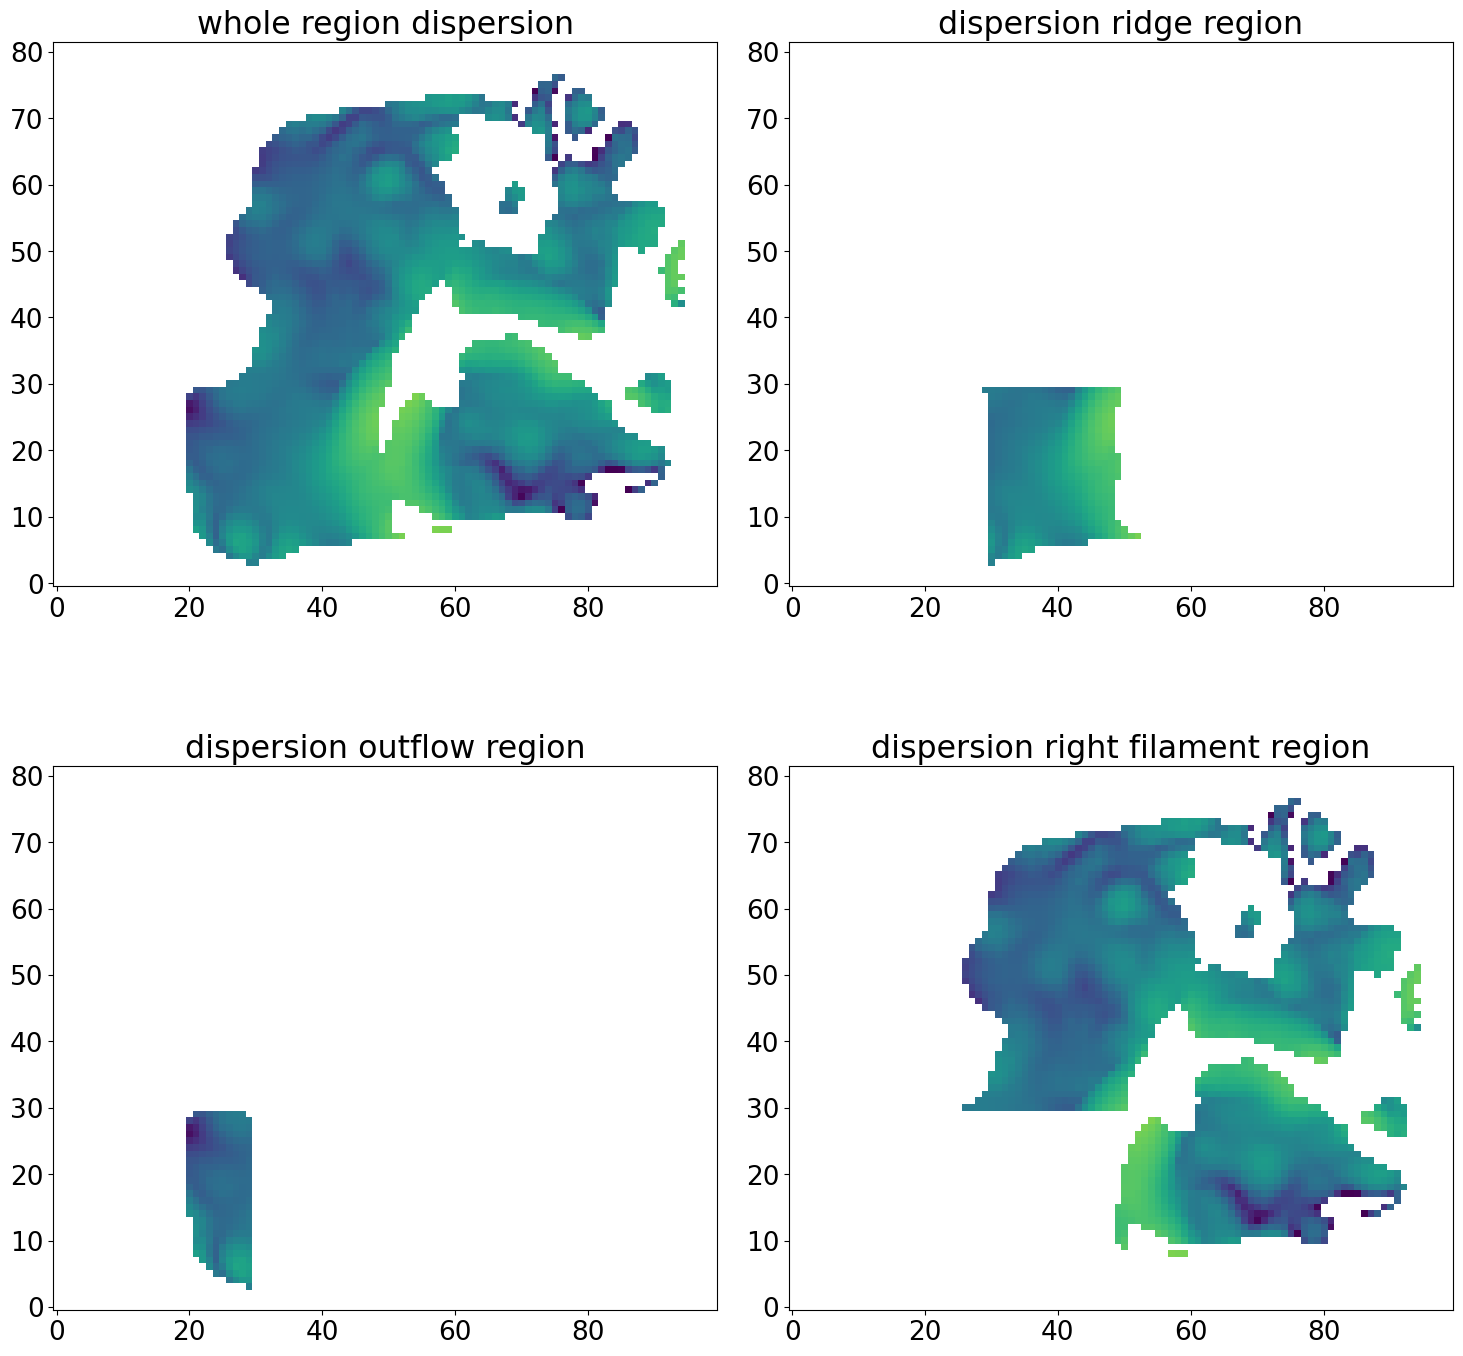

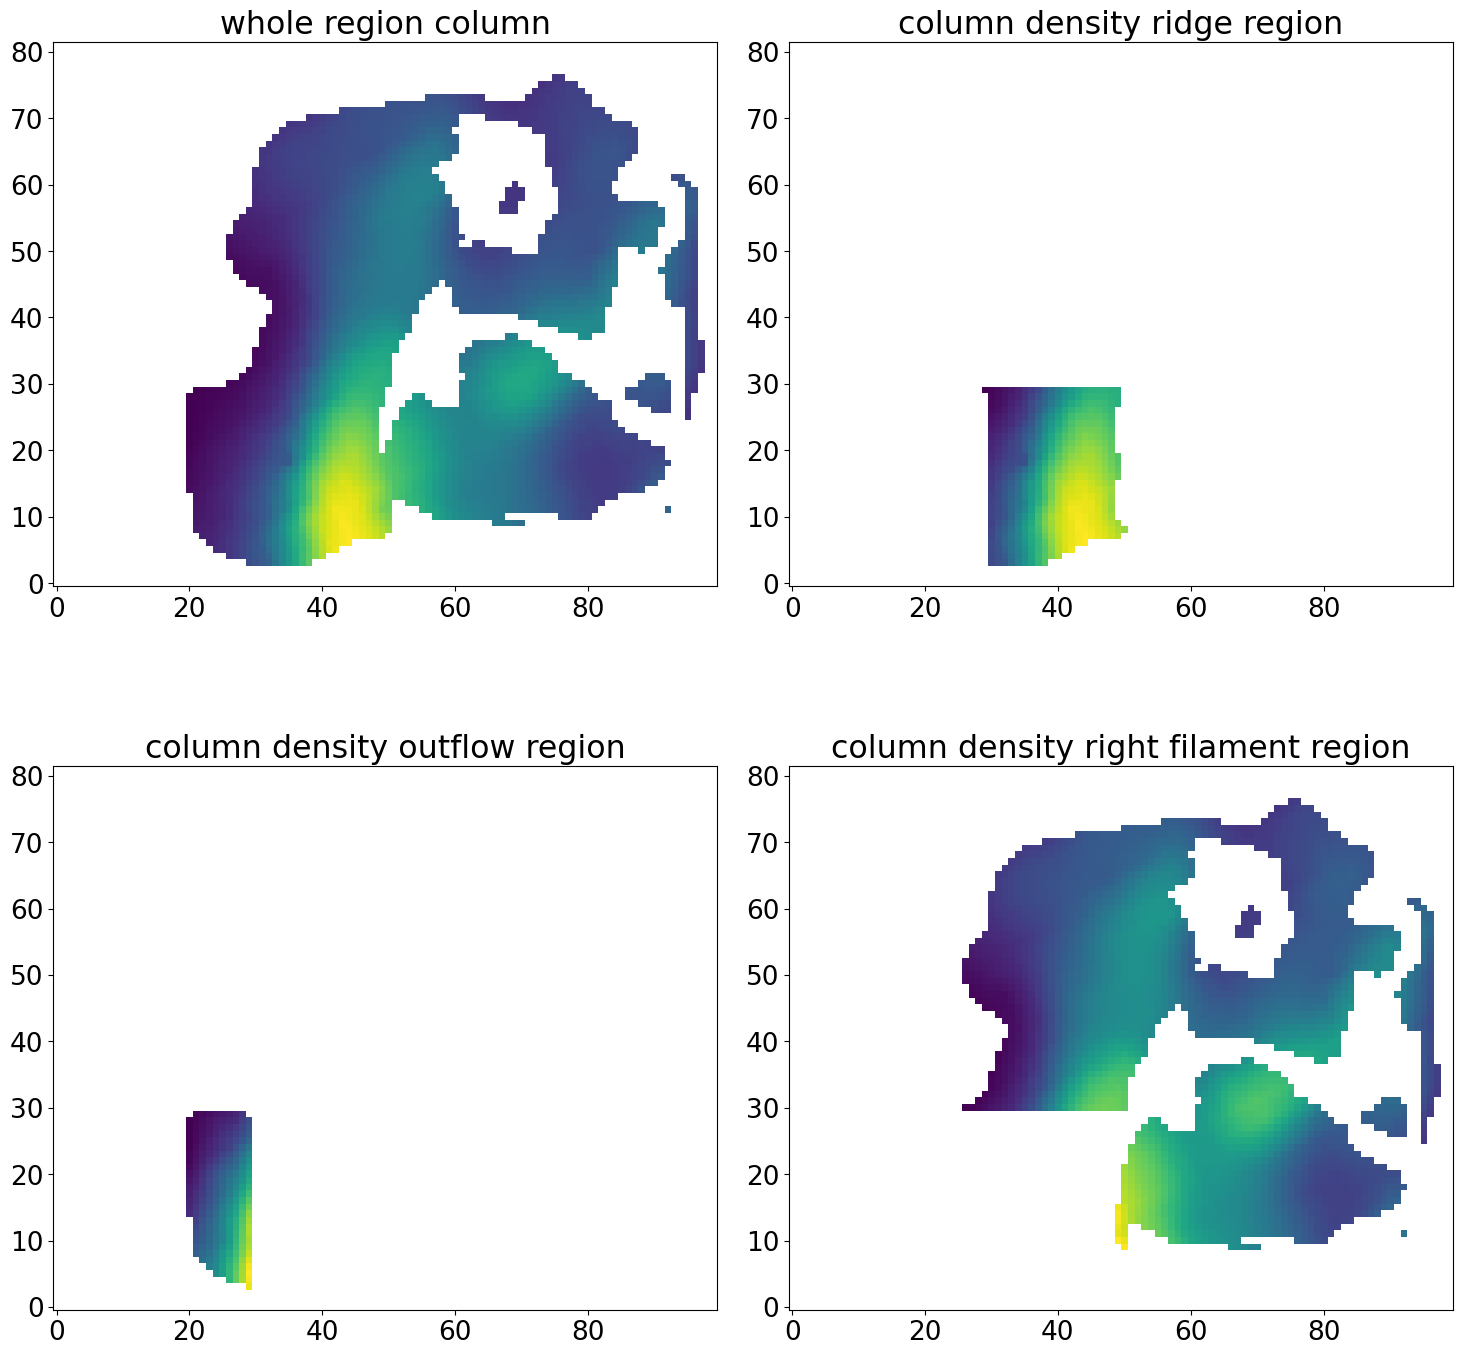

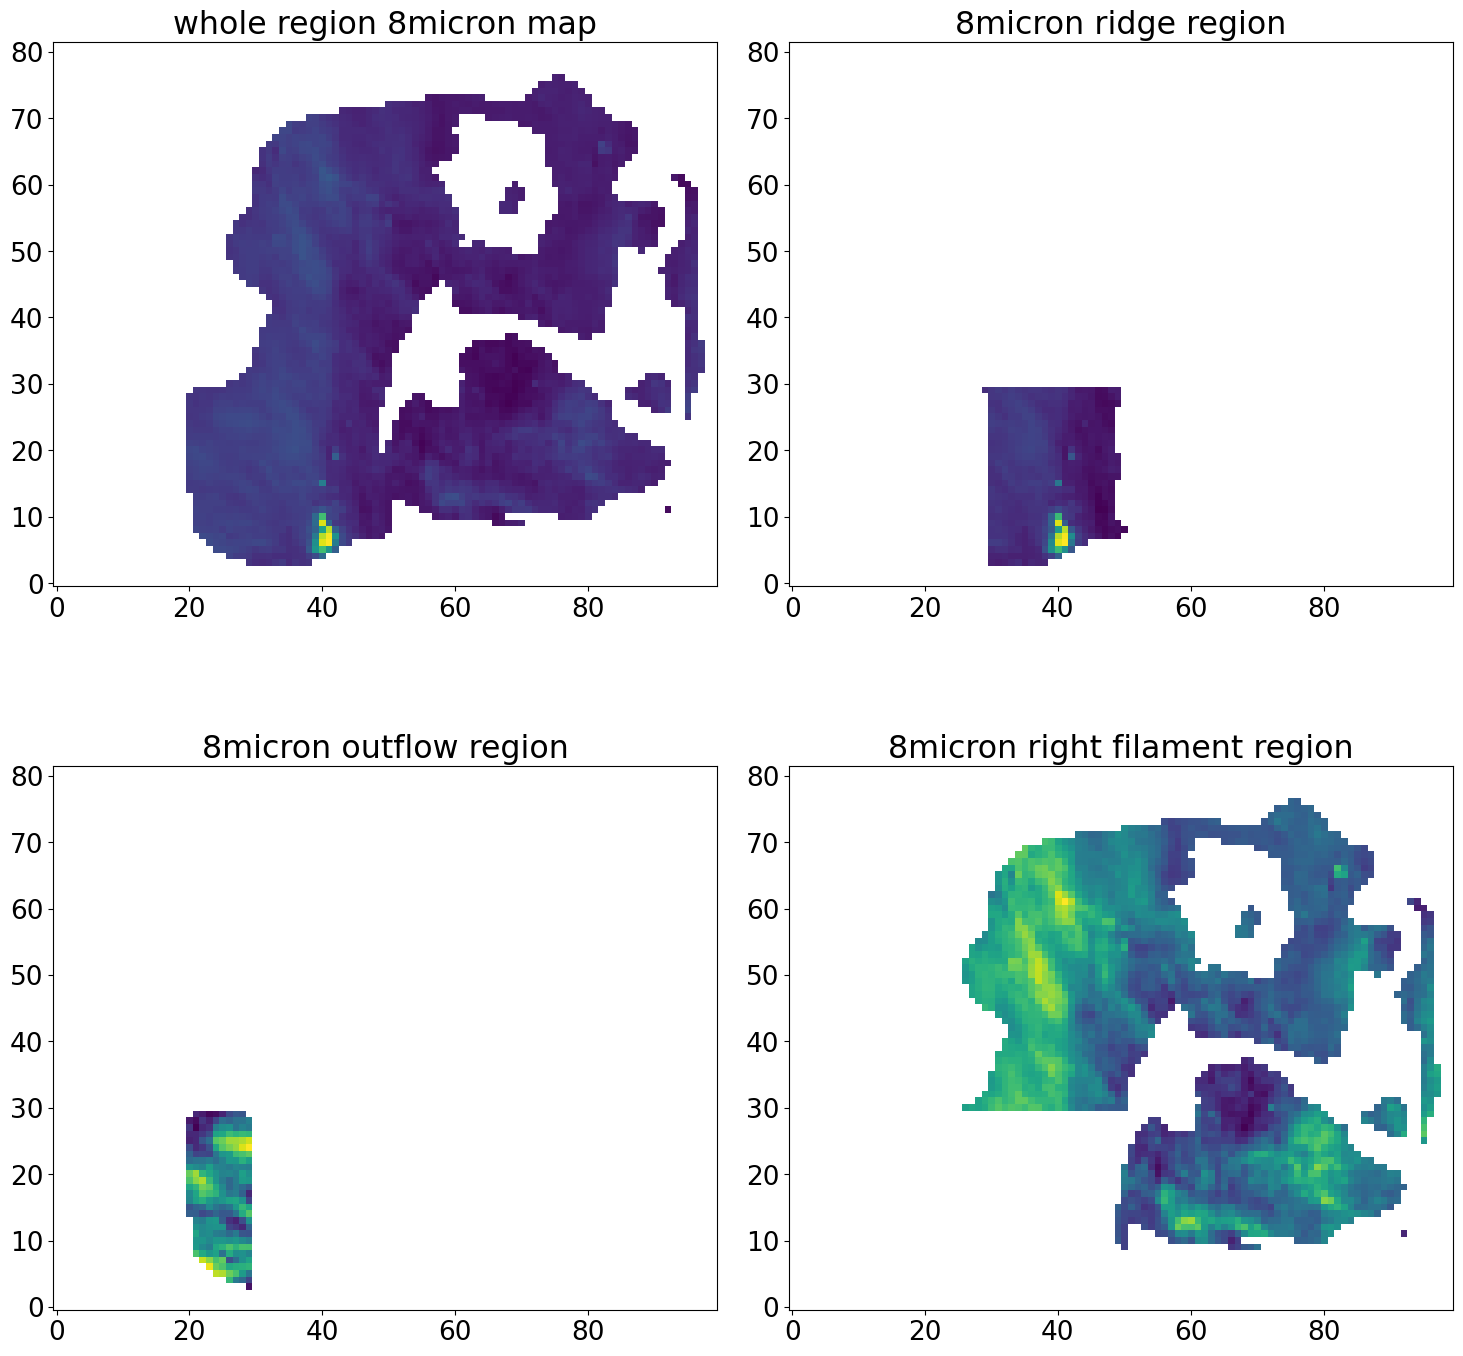

In [11]:
def line_1(x, y):
    top_x = 309.9258719
    top_y = 42.4556451
    bottom_x = 309.7452960
    bottom_y =   42.4556451
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_2(x, y):
    top_x = 309.7838598
    top_y = 42.4569364
    bottom_x = 309.7792727
    bottom_y =  42.3127837
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_3(x, y):
    top_x = 309.7468561
    top_y = 42.4529922
    bottom_x = 309.7507272
    bottom_y =  42.4299500
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_4(x, y):
    top_x = 309.7507272
    top_y = 42.4305231
    bottom_x = 309.7108001
    bottom_y =  42.4094674
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_5(x, y):
    top_x = 309.7108001
    top_y = 42.4094674
    bottom_x = 309.699191
    bottom_y =  42.3710874
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

I_ridge_plus_fill_right= BlankedMapStokesI.copy()
p_ridge_plus_fill_right = BlankedMapPol.copy()
s_ridge_plus_fill_right = S_map_deb.copy()
nh2_ridge_plus_fill_right = BlankedMapColumnDensity.copy()
micron8_ridge_plus_fill_right = BlankedMap8Mircon.copy()

I_outflow = BlankedMapStokesI.copy()
p_outflow = BlankedMapPol.copy()
s_outflow = S_map_deb.copy()
nh2_outflow = BlankedMapColumnDensity.copy()
micron8_outflow = BlankedMap8Mircon.copy()


selector = (line_1(RA_grid,DEC_grid)<0)*(line_2(RA_grid,DEC_grid)<0)
I_ridge_plus_fill_right.data[selector] = np.nan
p_ridge_plus_fill_right.data[selector] = np.nan
s_ridge_plus_fill_right.data[selector] = np.nan
nh2_ridge_plus_fill_right.data[selector] = np.nan
micron8_ridge_plus_fill_right.data[selector] = np.nan

selector = ~selector
I_outflow.data[selector] = np.nan
p_outflow.data[selector] = np.nan
s_outflow.data[selector] = np.nan
nh2_outflow.data[selector] = np.nan
micron8_outflow.data[selector] = np.nan


I_fil_right = I_ridge_plus_fill_right.copy()
p_fil_right = p_ridge_plus_fill_right.copy()
s_fil_right = s_ridge_plus_fill_right.copy()
nh2_fil_right = nh2_ridge_plus_fill_right.copy()
micron8_fil_right = micron8_ridge_plus_fill_right.copy()

I_ridge = I_ridge_plus_fill_right.copy()
p_ridge = p_ridge_plus_fill_right.copy()
s_ridge = s_ridge_plus_fill_right.copy()
nh2_ridge = nh2_ridge_plus_fill_right.copy()
micron8_ridge = micron8_ridge_plus_fill_right.copy()


selector = (line_1(RA_grid,DEC_grid)>0)+ (line_3(RA_grid,DEC_grid)<0)*(line_4(RA_grid,DEC_grid)>0) + (line_5(RA_grid,DEC_grid)>0)
  
I_ridge.data[selector] = np.nan
p_ridge.data[selector] = np.nan
s_ridge.data[selector] = np.nan
nh2_ridge.data[selector] = np.nan
micron8_ridge.data[selector] = np.nan

selector = ~selector
I_fil_right.data[selector] = np.nan
p_fil_right.data[selector] = np.nan
s_fil_right.data[selector] = np.nan
nh2_fil_right.data[selector] = np.nan
micron8_fil_right.data[selector] = np.nan

fig = plt.subplots(figsize =(15, 15))
ax1 = plt.subplot(221)
ax1.imshow(np.log(BlankedMapStokesI.data),origin='lower',vmin=0,vmax = 5)
ax1.set_title('whole region intensity')
ax2 = plt.subplot(222)
ax2.imshow(np.log(I_ridge.data),origin = 'lower',vmin=0,vmax = 5)
ax2.set_title('intensity ridge region')
ax3 = plt.subplot(223)
ax3.imshow(np.log(I_outflow.data),origin = 'lower',vmin=0,vmax = 5)
ax3.set_title('intensity outflow region')
ax4 = plt.subplot(224)
ax4.imshow(np.log(I_fil_right.data),origin = 'lower',vmin=0,vmax = 5)
ax4.set_title('intensity right filament region')
plt.tight_layout()
plt.show()

fig = plt.subplots(figsize =(15, 15))
ax1 = plt.subplot(221)
ax1.imshow(np.log(BlankedMapPol.data),origin='lower',vmin=0,vmax = 5)
ax1.set_title('whole region pfrac')
ax2 = plt.subplot(222)
ax2.imshow(np.log(p_ridge.data),origin = 'lower',vmin=0,vmax = 5)
ax2.set_title('pfrac ridge region')
ax3 = plt.subplot(223)
ax3.imshow(np.log(p_outflow.data),origin = 'lower',vmin=0,vmax = 5)
ax3.set_title('pfrac outflow region')
ax4 = plt.subplot(224)
ax4.imshow(np.log(p_fil_right.data),origin = 'lower',vmin=0,vmax = 5)
ax4.set_title('pfrac right filament region')
plt.tight_layout()
plt.show()

fig = plt.subplots(figsize =(15, 15))
ax1 = plt.subplot(221)
ax1.imshow(np.log(S_map_deb.data),origin='lower',vmin=0,vmax = 5)
ax1.set_title('whole region dispersion')
ax2 = plt.subplot(222)
ax2.imshow(np.log(s_ridge.data),origin = 'lower',vmin=0,vmax = 5)
ax2.set_title('dispersion ridge region')
ax3 = plt.subplot(223)
ax3.imshow(np.log(s_outflow.data),origin = 'lower',vmin=0,vmax = 5)
ax3.set_title('dispersion outflow region')
ax4 = plt.subplot(224)
ax4.imshow(np.log(s_fil_right.data),origin = 'lower',vmin=0,vmax = 5)
ax4.set_title('dispersion right filament region')
plt.tight_layout()
plt.show()


fig = plt.subplots(figsize =(15, 15))
ax1 = plt.subplot(221)
ax1.imshow(np.log(BlankedMapColumnDensity.data),origin='lower')
ax1.set_title('whole region column')
ax2 = plt.subplot(222)
ax2.imshow(np.log(nh2_ridge.data),origin = 'lower')
ax2.set_title('column density ridge region')
ax3 = plt.subplot(223)
ax3.imshow(np.log(nh2_outflow.data),origin = 'lower')
ax3.set_title('column density outflow region')
ax4 = plt.subplot(224)
ax4.imshow(np.log(nh2_fil_right.data),origin = 'lower')
ax4.set_title('column density right filament region')
plt.tight_layout()
plt.show()

fig = plt.subplots(figsize =(15, 15))
ax1 = plt.subplot(221)
ax1.imshow(np.log(BlankedMap8Mircon.data),origin='lower')
ax1.set_title('whole region 8micron map')
ax2 = plt.subplot(222)
ax2.imshow(np.log(micron8_ridge.data),origin = 'lower')
ax2.set_title('8micron ridge region')
ax3 = plt.subplot(223)
ax3.imshow(np.log(micron8_outflow.data),origin = 'lower')
ax3.set_title('8micron outflow region')
ax4 = plt.subplot(224)
ax4.imshow(np.log(micron8_fil_right.data),origin = 'lower')
ax4.set_title('8micron right filament region')
plt.tight_layout()
plt.show()


In [63]:
# # I_outflow.writeto('outflow.fits')
# # I_fil_right.writeto('fil_right.fits')
# # I_ridge.writeto('ridge.fits')
# # matplotlib.image.imsave('../ridge.png', I_ridge.data,origin='lower',vmin=0,vmax=50)
# # matplotlib.image.imsave('../right_fil.png', I_fil_right.data,origin='lower',vmin=0,vmax=50)
# # matplotlib.image.imsave('../outflow.png', I_outflow.data,origin='lower',vmin=0,vmax=50)
# # matplotlib.image.imsave('../Her250.png', MapHer250.data,cmap='Greys',origin='lower',vmin=0,vmax=50)
# matplotlib.image.imsave('../Pfrac.png', BlankedMapPol.data,origin='lower',vmin=0,vmax=50)

# print(I_ridge.data.shape)




(93, 110)


Analysis of the ridge region

C : 12.409115883670607
s index : -0.926707510093471
nh2 index : -0.47668551829604844


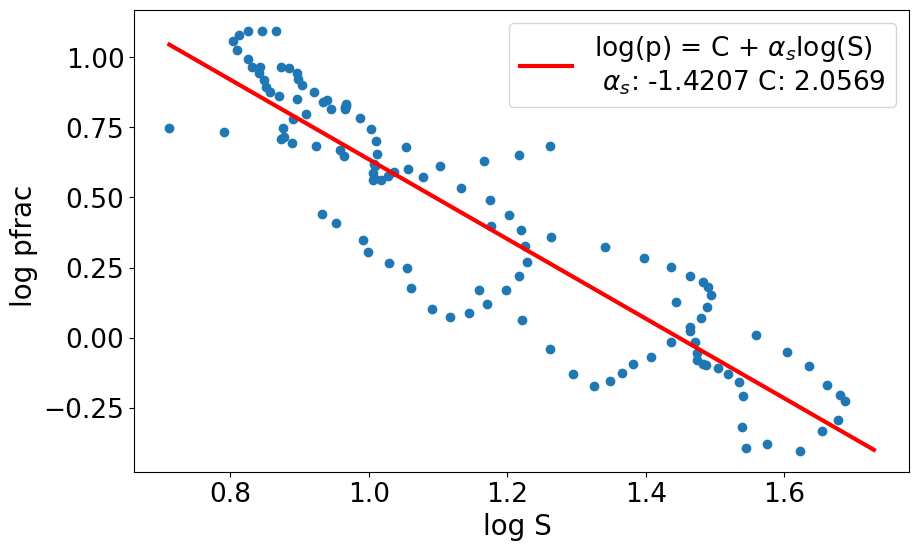

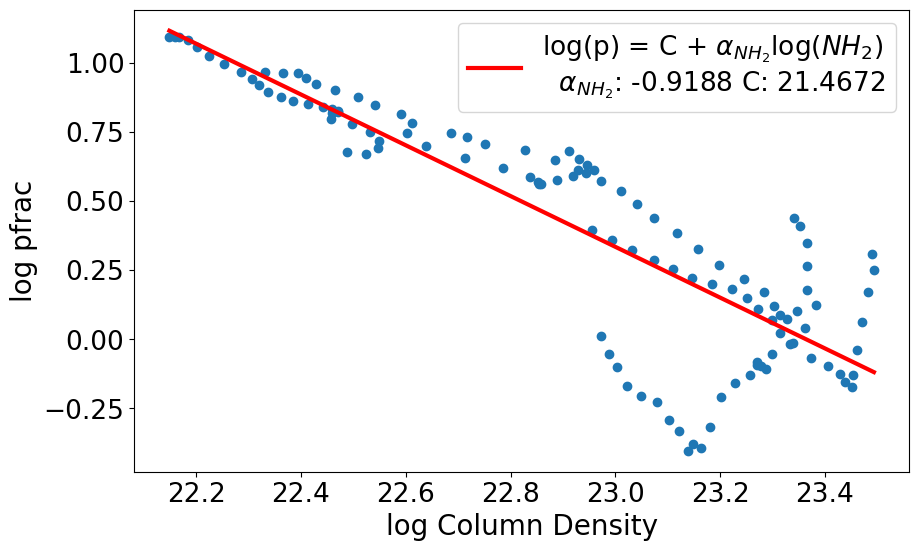

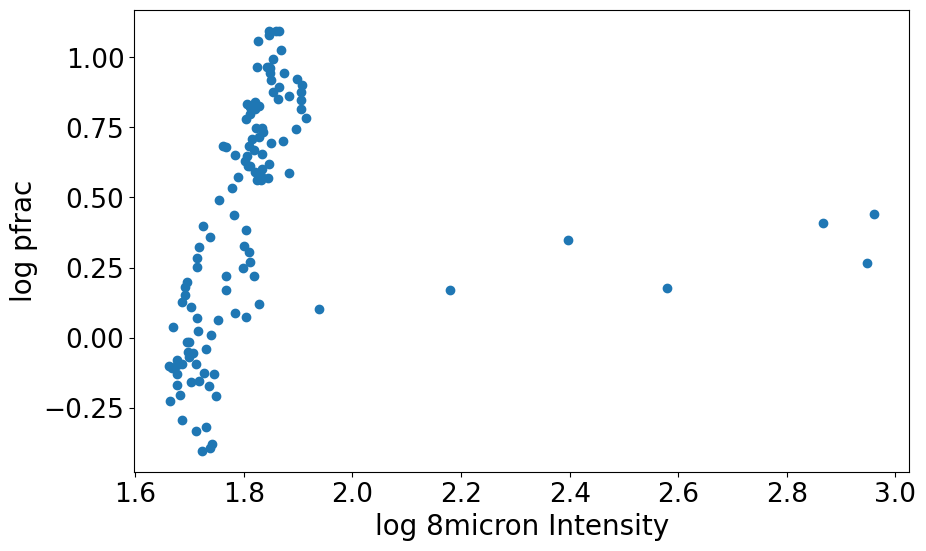

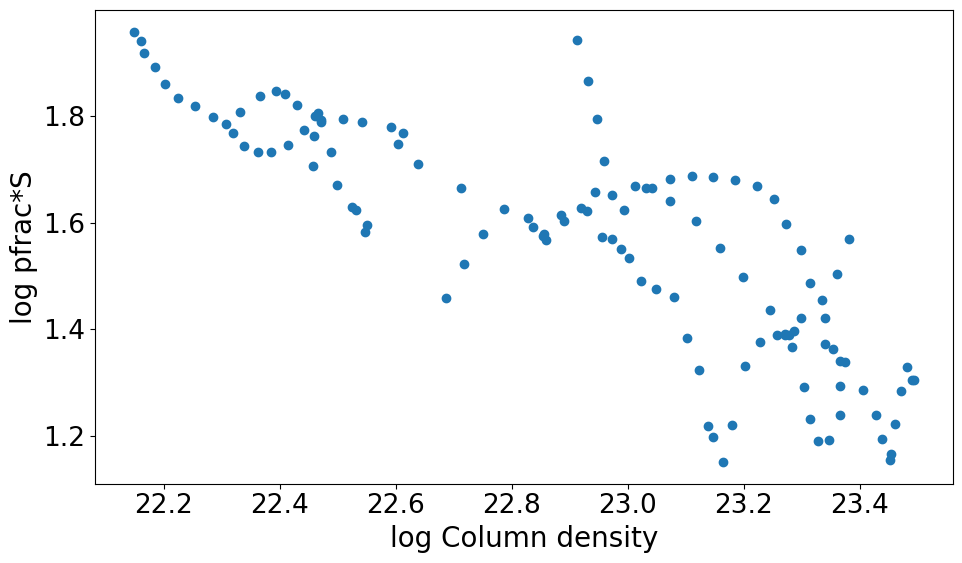

In [12]:
def lin_fit(x, a, b):
    return a + b*x

def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

####### changing data to array
s_ridge_array = s_ridge.data.flatten()
p_ridge_array = p_ridge.data.flatten()
I_ridge_array = I_ridge.data.flatten()
nh2_ridge_array = nh2_ridge.data.flatten()
micron8_ridge_array = micron8_ridge.data.flatten()

######## making the data points independent
s_ridge_array_ind = s_ridge_array.copy()
s_ridge_array_ind = s_ridge_array_ind[::4]
p_ridge_array_ind = p_ridge_array.copy()
p_ridge_array_ind = p_ridge_array_ind[::4]
I_ridge_array_ind = I_ridge_array.copy()
I_ridge_array_ind = I_ridge_array_ind[::4]
nh2_ridge_array_ind = nh2_ridge_array.copy()
nh2_ridge_array_ind = nh2_ridge_array_ind[::4]
micron8_ridge_array_ind = micron8_ridge_array.copy()
micron8_ridge_array_ind = micron8_ridge_array_ind[::4]


######### taking log10 of the data
log_s = np.log10(s_ridge_array_ind)
log_p = np.log10(p_ridge_array_ind)
log_I = np.log10(I_ridge_array_ind)
log_nh2 = np.log10(nh2_ridge_array_ind)
log_8micron = np.log10(micron8_ridge_array_ind)


###### making bins for curve fitting
p_min = np.nanmin(log_p)
p_max = np.nanmax(log_p)
s_min = np.nanmin(log_s)
s_max = np.nanmax(log_s)
I_min = np.nanmin(log_I)
I_max = np.nanmax(log_I)
nh2_min = np.nanmin(log_nh2)
nh2_max = np.nanmax(log_nh2)

p_bins = np.linspace(p_min, p_max, 100)
s_bins = np.linspace(s_min, s_max, 100)
I_bins = np.linspace(I_min, I_max, 100)
nh2_bins = np.linspace(nh2_min,nh2_max, 100)


######## Fitting the data 
df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'logI':log_I,'lognh2':log_nh2})
df_log = df_log.dropna()

####### single parameter fitting
PS_ridge_param, PS_ridge_param_cov = curve_fit(lin_fit, df_log['logs'], df_log['logp'])
PS_FitFunc_ridge = lin_fit(s_bins,PS_ridge_param[0],PS_ridge_param[1])
# print(PS_lower_param[0],PS_lower_param[1])

PI_ridge_param, PI_ridge_param_cov = curve_fit(lin_fit, df_log['logI'], df_log['logp'])
PI_FitFunc_ridge = lin_fit(I_bins,PI_ridge_param[0],PI_ridge_param[1])
# print(PI_upper_param[0],PI_upper_param[1])

Pnh2_ridge_param, Pnh2_ridge_param_cov = curve_fit(lin_fit, df_log['lognh2'], df_log['logp'])
Pnh2_FitFunc_ridge = lin_fit(nh2_bins,Pnh2_ridge_param[0],Pnh2_ridge_param[1])

###### Double parameter fitting
# p0 = -0.2278,-0.3994,2.
# PSI_param_lower, PSI_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['logI']), df_log['logp'],p0)
# print('C :',PSI_param_lower[0])
# print('s index :',PSI_param_lower[1])
# print('I index :',PSI_param_lower[2])

p0 = -0.2278, -0.8567, 2.
PSnh2_param_lower, PSnh2_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['lognh2']), df_log['logp'],p0)
print('C :',PSnh2_param_lower[0])
print('s index :',PSnh2_param_lower[1])
print('nh2 index :',PSnh2_param_lower[2])


######### plotting the graphs
fig = plt.subplots(figsize =(10, 6))
ax1 = plt.subplot(111)
ax1.scatter(log_s,log_p)
label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_ridge_param[1],C = PS_ridge_param[0],linebreak='\n')
ax1.plot(s_bins,PS_FitFunc_ridge,'r',linewidth=3,label = label_temp)
ax1.set_ylabel('log pfrac ',fontdict={'fontsize':20})
ax1.set_xlabel('log S ',fontdict={'fontsize':20})


# fig = plt.subplots(figsize =(10, 6))
# ax2 = plt.subplot(111)
# ax2.scatter(log_I,log_p)
# label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_ridge_param[1],C = PI_ridge_param[0],linebreak='\n')
# ax2.plot(I_bins,PI_FitFunc_ridge,'r',linewidth=3,label = label_temp)
# ax2.set_ylabel('log p')
# ax2.set_xlabel('log I')


fig = plt.subplots(figsize =(10, 6))
ax3 = plt.subplot(111)
ax3.scatter(log_nh2,log_p)
label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_ridge_param[1],C = Pnh2_ridge_param[0],linebreak='\n')
ax3.plot(nh2_bins,Pnh2_FitFunc_ridge,'r',linewidth=3,label = label_temp)
ax3.set_ylabel('log pfrac',fontdict={'fontsize':20})
ax3.set_xlabel('log Column Density',fontdict={'fontsize':20})


fig = plt.subplots(figsize =(10, 6))
ax4 = plt.subplot(111)
ax4.scatter(log_8micron,log_p)
ax4.set_ylabel('log pfrac',fontdict={'fontsize':20})
ax4.set_xlabel('log 8micron Intensity',fontdict={'fontsize':20})


fig = plt.subplots(figsize =(10, 6))
ax5 = plt.subplot(111)
ax5.scatter(np.log10(nh2_ridge_array_ind),np.log10(p_ridge_array_ind*s_ridge_array_ind))
# label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_param[1],C = Pnh2_param[0],linebreak='\n')
# ax4.set_title("whole region log pfrac vs log 8micron intensity")
ax5.set_ylabel('log pfrac*S',fontdict={'fontsize':20})
ax5.set_xlabel('log Column density',fontdict={'fontsize':20})



ax1.legend()
ax3.legend()
plt.tight_layout()
plt.show()


Bootstrap error Ridge region

In [13]:
s_ridge_array = s_ridge.data.flatten()
p_ridge_array = p_ridge.data.flatten()
nh2_ridge_array = nh2_ridge.data.flatten()

log_s = np.log(s_ridge_array)
log_p = np.log(p_ridge_array)
log_nh2 = np.log(nh2_ridge_array)

df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'lognh2':log_nh2})
df_log = df_log.dropna()

def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

def curve_fitting(x):
    param, param_cov = curve_fit(DoubleParamFunc,(x[:,2],x[:,1]),x[:,0])
    return np.sqrt(np.diag(param_cov))


bootarr = np.array(df_log)

bootresult = bootstrap(bootarr,10000,bootfunc=curve_fitting)
print('error in alpha_s',np.std(bootresult[:,1]))
print('error in alpha_nh2',np.std(bootresult[:,2]))

# param, param_cov = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['lognh2']),df_log['logp'])
# param_cov = curve_fitting(bootarr)



error in alpha_s 0.0008646518369903179
error in alpha_nh2 0.0013157053422999407


Analysis of the Sub-filament region

C : 22.935533838806204
s index : -0.35011764596983636
nh2 index : -0.9802582731774576


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


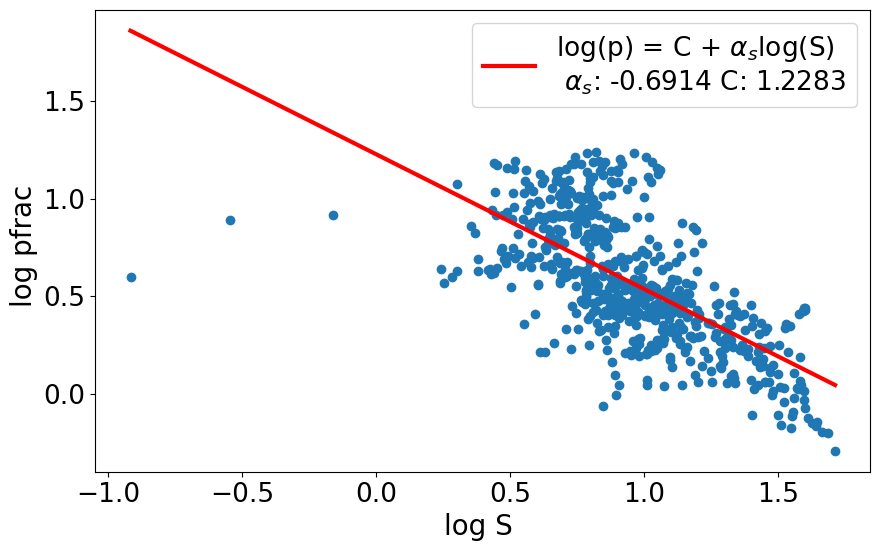

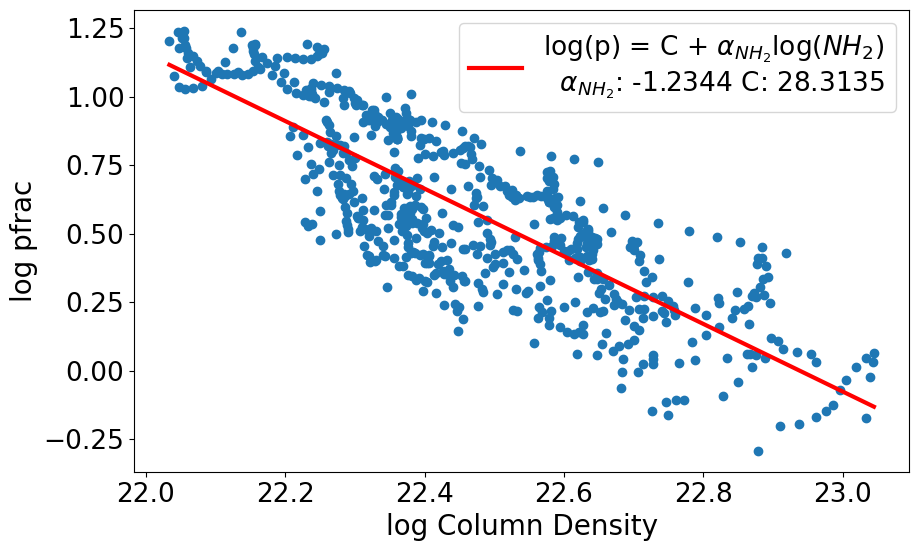

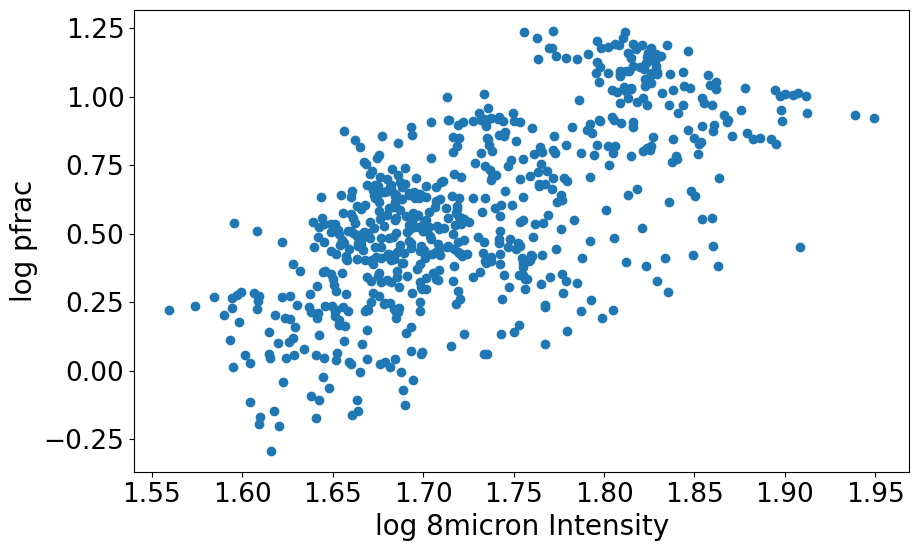

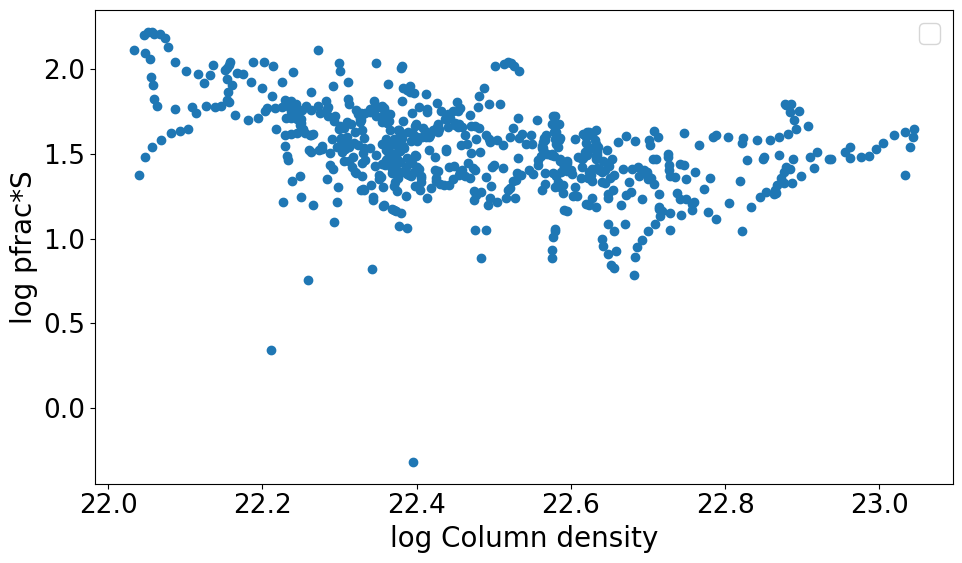

In [14]:
def lin_fit(x, a, b):
    return a + b*x


def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y


####### changing data to array
s_fil_right_array = s_fil_right.data.flatten()
p_fil_right_array = p_fil_right.data.flatten()
I_fil_right_array = I_fil_right.data.flatten()
nh2_fil_right_array = nh2_fil_right.data.flatten()
micron8_fil_right_array = micron8_fil_right.data.flatten()


######## making the data points independent
s_fil_right_array_ind = s_fil_right_array.copy()
s_fil_right_array_ind = s_fil_right_array_ind[::4]
p_fil_right_array_ind = p_fil_right_array.copy()
p_fil_right_array_ind = p_fil_right_array_ind[::4]
I_fil_right_array_ind = I_fil_right_array.copy()
I_fil_right_array_ind = I_fil_right_array_ind[::4]
nh2_fil_right_array_ind = nh2_fil_right_array.copy()
nh2_fil_right_array_ind = nh2_fil_right_array_ind[::4]
micron8_fil_right_array_ind = micron8_fil_right_array.copy()
micron8_fil_right_array_ind = micron8_fil_right_array_ind[::4]


######## taking log10 of the data
log_s = np.log10(s_fil_right_array_ind)
log_p = np.log10(p_fil_right_array_ind)
log_I = np.log10(I_fil_right_array_ind)
log_nh2 = np.log10(nh2_fil_right_array_ind)
log_8micron = np.log10(micron8_fil_right_array_ind)


###### making bins for curve fitting
p_min = np.nanmin(log_p)
p_max = np.nanmax(log_p)
s_min = np.nanmin(log_s)
s_max = np.nanmax(log_s)
I_min = np.nanmin(log_I)
I_max = np.nanmax(log_I)
nh2_min = np.nanmin(log_nh2)
nh2_max = np.nanmax(log_nh2)
micron8_min = np.nanmin(log_8micron)
micron8_max = np.nanmax(log_8micron)  

p_bins = np.linspace(p_min, p_max, 100)
s_bins = np.linspace(s_min, s_max, 100)
I_bins = np.linspace(I_min, I_max, 100)
nh2_bins = np.linspace(nh2_min,nh2_max, 100)
micron8_bins = np.linspace(micron8_min,micron8_max,100)


######## curve fitting
df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'logI':log_I,'lognh2':log_nh2})
df_log = df_log.dropna()

###### single parameter fitting
PS_fil_right_param, PS_fil_right_param_cov = curve_fit(lin_fit, df_log['logs'], df_log['logp'])
PS_FitFunc_fil_right = lin_fit(s_bins,PS_fil_right_param[0],PS_fil_right_param[1])
# print(PS_lower_param[0],PS_lower_param[1])

PI_fil_right_param, PI_fil_right_param_cov = curve_fit(lin_fit, df_log['logI'], df_log['logp'])
PI_FitFunc_fil_right = lin_fit(I_bins,PI_fil_right_param[0],PI_fil_right_param[1])
# print(PI_upper_param[0],PI_upper_param[1])

Pnh2_fil_right_param, Pnh2_fil_right_param_cov = curve_fit(lin_fit, df_log['lognh2'], df_log['logp'])
Pnh2_FitFunc_fil_right = lin_fit(nh2_bins,Pnh2_fil_right_param[0],Pnh2_fil_right_param[1])


##### Double parameter fitting
# p0 = -0.2278,-0.3994,2.
# PSI_param_lower, PSI_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['logI']), df_log['logp'],p0)
# print('C :',PSI_param_lower[0])
# print('s index :',PSI_param_lower[1])
# print('I index :',PSI_param_lower[2])

p0 = -0.2278, -0.8567, 2.
PSNH2_param_lower, PSNH2_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['lognh2']), df_log['logp'],p0)
print('C :',PSNH2_param_lower[0])
print('s index :',PSNH2_param_lower[1])
print('nh2 index :',PSNH2_param_lower[2])



######### plotting the graphs
fig = plt.subplots(figsize =(10, 6))
ax1 = plt.subplot(111)
ax1.scatter(log_s,log_p)
label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_fil_right_param[1],C = PS_fil_right_param[0],linebreak='\n')
ax1.plot(s_bins,PS_FitFunc_fil_right,'r',linewidth=3,label = label_temp)
ax1.set_ylabel('log pfrac ',fontdict={'fontsize':20})
ax1.set_xlabel('log S ',fontdict={'fontsize':20})


# fig = plt.subplots(figsize =(10, 6))
# ax2 = plt.subplot(111)
# ax2.scatter(log_I,log_p)
# label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_fil_right_param[1],C = PI_fil_right_param[0],linebreak='\n')
# ax2.plot(I_bins,PI_FitFunc_fil_right,'r',linewidth=3,label = label_temp)
# ax2.set_ylabel('log p')
# ax2.set_xlabel('log I')


fig = plt.subplots(figsize =(10, 6))
ax3 = plt.subplot(111)
ax3.scatter(log_nh2,log_p)
label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_fil_right_param[1],C = Pnh2_fil_right_param[0],linebreak='\n')
ax3.plot(nh2_bins,Pnh2_FitFunc_fil_right,'r',linewidth=3,label = label_temp)
ax3.set_ylabel('log pfrac',fontdict={'fontsize':20})
ax3.set_xlabel('log Column Density',fontdict={'fontsize':20})


fig = plt.subplots(figsize =(10, 6))
ax4 = plt.subplot(111)
ax4.scatter(log_8micron,log_p)
ax4.set_ylabel('log pfrac',fontdict={'fontsize':20})
ax4.set_xlabel('log 8micron Intensity',fontdict={'fontsize':20})


fig = plt.subplots(figsize =(10, 6))
ax5 = plt.subplot(111)
ax5.scatter(np.log10(nh2_fil_right_array_ind),np.log10(p_fil_right_array_ind*s_fil_right_array_ind))
ax5.set_ylabel('log pfrac*S',fontdict={'fontsize':20})
ax5.set_xlabel('log Column density',fontdict={'fontsize':20})



ax1.legend()
ax3.legend()
plt.legend()
plt.tight_layout()
plt.show()



Bootstrap error Sub-filament region.

In [15]:
s_fil_right_array = s_fil_right.data.flatten()
p_fil_right_array = p_fil_right.data.flatten()
nh2_fil_right_array = nh2_fil_right.data.flatten()

log_s = np.log(s_fil_right_array)
log_p = np.log(p_fil_right_array)
log_nh2 = np.log(nh2_fil_right_array)

df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'lognh2':log_nh2})
df_log = df_log.dropna()

def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

def curve_fitting(x):
    param, param_cov = curve_fit(DoubleParamFunc,(x[:,2],x[:,1]),x[:,0])
    return np.sqrt(np.diag(param_cov))


bootarr = np.array(df_log)


bootresult = bootstrap(bootarr,10000,bootfunc=curve_fitting)
print('error in alpha_s',np.std(bootresult[:,1]))
print('error in alpha_nh2',np.std(bootresult[:,2]))

# param, param_cov = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['lognh2']),df_log['logp'])
# param_cov = curve_fitting(bootarr)

error in alpha_s 0.0002727300523095694
error in alpha_nh2 0.00023813748618024263


Analysis of the outflow region

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


C : 20.780656172794476
s index : -0.24700397408789732
nh2 index : -0.8835747472511606


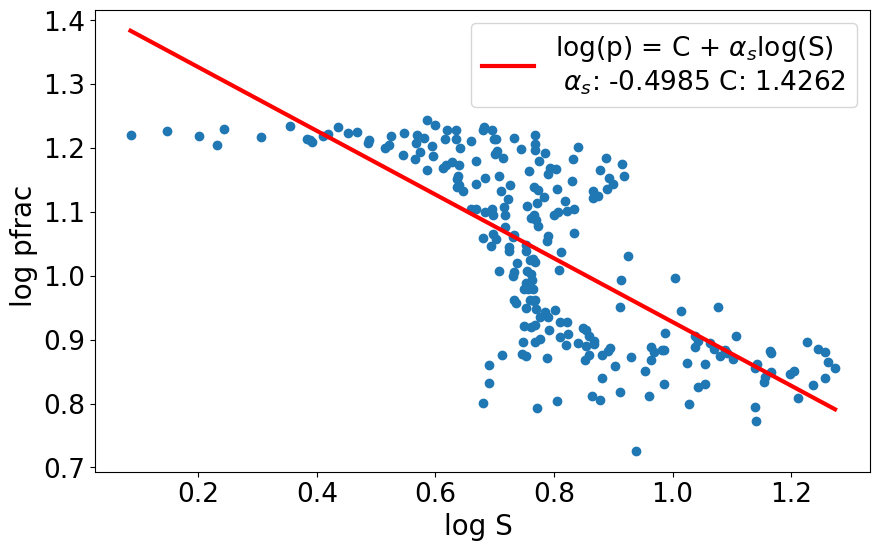

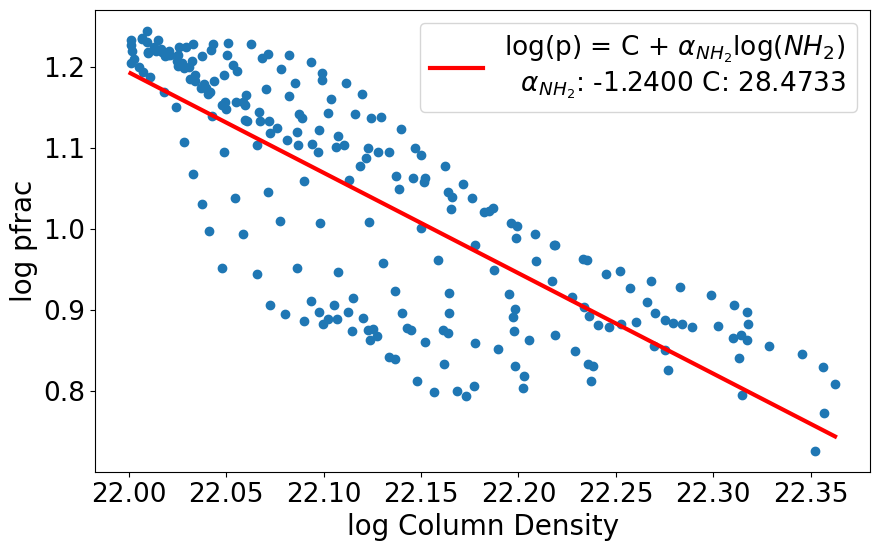

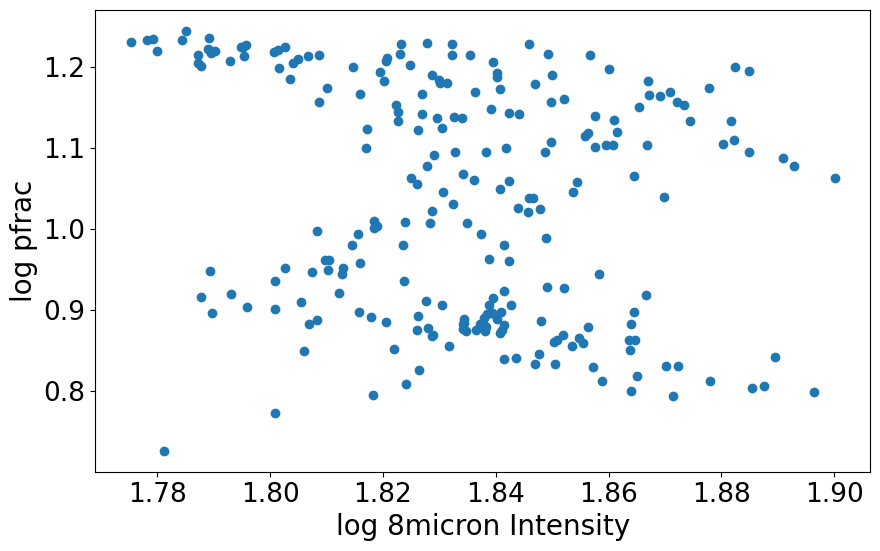

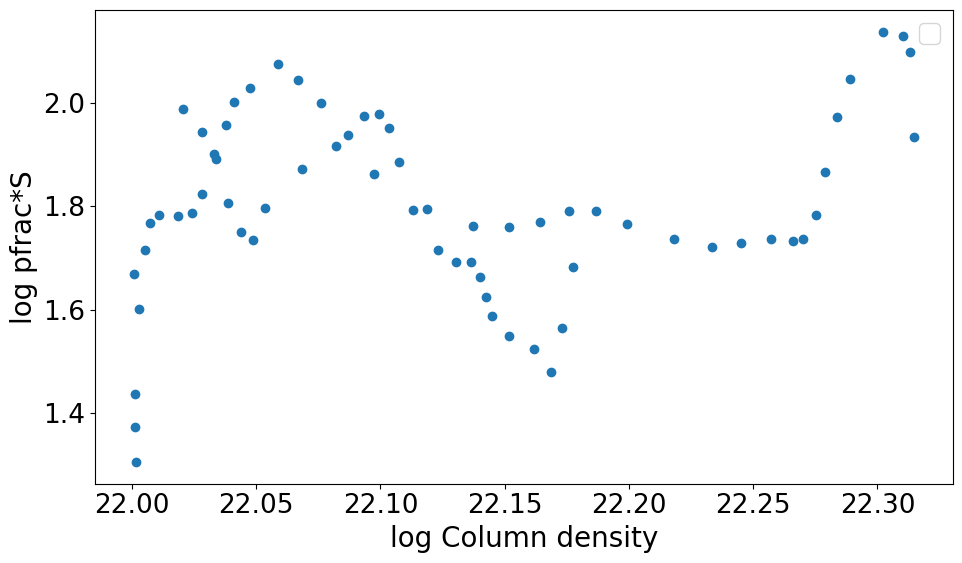

In [20]:
def lin_fit(x, a, b):
    return a + b*x

def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

######## changing data to array
s_outflow_array = s_outflow.data.flatten()
p_outflow_array = p_outflow.data.flatten()
I_outflow_array = I_outflow.data.flatten()
nh2_outflow_array = nh2_outflow.data.flatten()
micron8_outflow_array = micron8_outflow.data.flatten()

s_outflow_array_ind = s_outflow_array.copy()
s_outflow_array_ind = s_outflow_array_ind[::4]
p_outflow_array_ind = p_outflow_array.copy()
p_outflow_array_ind = p_outflow_array_ind[::4]
I_outflow_array_ind = I_outflow_array.copy()
I_outflow_array_ind = I_outflow_array_ind[::4]
nh2_outflow_array_ind = nh2_outflow_array.copy()
nh2_outflow_array_ind = nh2_outflow_array_ind[::4]
micron8_outflow_array_ind = micron8_outflow_array.copy()
micron8_outflow_array_ind = micron8_outflow_array_ind[::4]


####### taking log10 of the data
log_s = np.log10(s_outflow_array)
log_p = np.log10(p_outflow_array)
log_I = np.log10(I_outflow_array)
log_nh2 = np.log10(nh2_outflow_array)
log_8micron = np.log10(micron8_outflow_array)


###### making bins for curve fitting
p_min = np.nanmin(log_p)
p_max = np.nanmax(log_p)
s_min = np.nanmin(log_s)
s_max = np.nanmax(log_s)
I_min = np.nanmin(log_I)
I_max = np.nanmax(log_I)
nh2_min = np.nanmin(log_nh2)
nh2_max = np.nanmax(log_nh2)
micron8_min = np.nanmin(log_8micron)
micron8_max = np.nanmax(log_8micron)  

p_bins = np.linspace(p_min, p_max, 100)
s_bins = np.linspace(s_min, s_max, 100)
I_bins = np.linspace(I_min, I_max, 100)
nh2_bins = np.linspace(nh2_min,nh2_max, 100)
micron8_bins = np.linspace(micron8_min,micron8_max,100)


######## fitting the data
df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'logI':log_I,'lognh2':log_nh2,'log_8micron':log_8micron})
df_log = df_log.dropna()

###### single parameter fitting
PS_outflow_param, PS_outflow_param_cov = curve_fit(lin_fit, df_log['logs'], df_log['logp'])
PS_FitFunc_outflow = lin_fit(s_bins,PS_outflow_param[0],PS_outflow_param[1])
# print(PS_lower_param[0],PS_lower_param[1])

PI_outflow_param, PI_outflow_param_cov = curve_fit(lin_fit, df_log['logI'], df_log['logp'])
PI_FitFunc_outflow = lin_fit(I_bins,PI_outflow_param[0],PI_outflow_param[1])
# print(PI_upper_param[0],PI_upper_param[1])

Pnh2_outflow_param, Pnh2_outflow_param_cov = curve_fit(lin_fit, df_log['lognh2'], df_log['logp'])
Pnh2_FitFunc_outflow = lin_fit(nh2_bins,Pnh2_outflow_param[0],Pnh2_outflow_param[1])


###### double parameter fitting
# p0 = -0.2278,-0.3994,2.
# PSI_param_lower, PSI_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['logI']), df_log['logp'],p0)
# print('C :',PSI_param_lower[0])
# print('s index :',PSI_param_lower[1])
# print('I index :',PSI_param_lower[2])

p0 = -0.2278, -0.8567, 2.
PSNH2_param_lower, PSNH2_param_cov_lower = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['lognh2']), df_log['logp'],p0)
print('C :',PSNH2_param_lower[0])
print('s index :',PSNH2_param_lower[1])
print('nh2 index :',PSNH2_param_lower[2])


######### plotting the graphs
fig = plt.subplots(figsize =(10, 6))
ax1 = plt.subplot(111)
ax1.scatter(log_s,log_p)
label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = PS_outflow_param[1],C = PS_outflow_param[0],linebreak='\n')
ax1.plot(s_bins,PS_FitFunc_outflow,'r',linewidth=3,label = label_temp)
ax1.set_ylabel('log pfrac ',fontdict={'fontsize':20})
ax1.set_xlabel('log S ',fontdict={'fontsize':20})


# fig = plt.subplots(figsize =(10, 6))
# ax2 = plt.subplot(111)
# ax2.scatter(log_I,log_p)
# label_temp = r'log(p) = C + $\alpha_I$log(I){linebreak} $\alpha_I$: {alpha_I:.4f} C: {C:.4f}'.format(alpha_I = PI_fil_right_param[1],C = PI_fil_right_param[0],linebreak='\n')
# ax2.plot(I_bins,PI_FitFunc_fil_right,'r',linewidth=3,label = label_temp)
# ax2.set_ylabel('log p')
# ax2.set_xlabel('log I')


fig = plt.subplots(figsize =(10, 6))
ax3 = plt.subplot(111)
ax3.scatter(log_nh2,log_p)
label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = Pnh2_outflow_param[1],C = Pnh2_outflow_param[0],linebreak='\n')
ax3.plot(nh2_bins,Pnh2_FitFunc_outflow,'r',linewidth=3,label = label_temp)
ax3.set_ylabel('log pfrac',fontdict={'fontsize':20})
ax3.set_xlabel('log Column Density',fontdict={'fontsize':20})


fig = plt.subplots(figsize =(10, 6))
ax4 = plt.subplot(111)
ax4.scatter(log_8micron,log_p)
ax4.set_ylabel('log pfrac',fontdict={'fontsize':20})
ax4.set_xlabel('log 8micron Intensity',fontdict={'fontsize':20})


fig = plt.subplots(figsize =(10, 6))
ax5 = plt.subplot(111)
ax5.scatter(np.log10(nh2_outflow_array_ind),np.log10(p_outflow_array_ind*s_outflow_array_ind))
ax5.set_ylabel('log pfrac*S',fontdict={'fontsize':20})
ax5.set_xlabel('log Column density',fontdict={'fontsize':20})


ax1.legend()
ax3.legend()
plt.legend()
plt.tight_layout()
plt.show()


Bootstrap error estimation of the outflow region

In [21]:
s_outflow_array = s_outflow.data.flatten()
p_outlfow_array =p_outflow.data.flatten()
nh2_outflow_array = nh2_outflow.data.flatten()

log_s = np.log(s_outflow_array)
log_p = np.log(p_outlfow_array)
log_nh2 = np.log(nh2_outflow_array)

df_log = pd.DataFrame({'logp': log_p,'logs':log_s,'lognh2':log_nh2})
df_log = df_log.dropna()

def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

def curve_fitting(x):
    param, param_cov = curve_fit(DoubleParamFunc,(x[:,2],x[:,1]),x[:,0])
    return np.sqrt(np.diag(param_cov))


bootarr = np.array(df_log)


bootresult = bootstrap(bootarr,10000,bootfunc=curve_fitting)
print('error in alpha_s',np.mean(bootresult[:,1]))
print('error in alpha_nh2',np.mean(bootresult[:,2]))

# param, param_cov = curve_fit(DoubleParamFunc,(df_log['logs'],df_log['lognh2']),df_log['logp'])
# param_cov = curve_fitting(bootarr)

error in alpha_s 0.07120624705441321
error in alpha_nh2 0.031684199546778556


Comaprision of 214 micron stokes I C2N data vs 250 micron Herschel

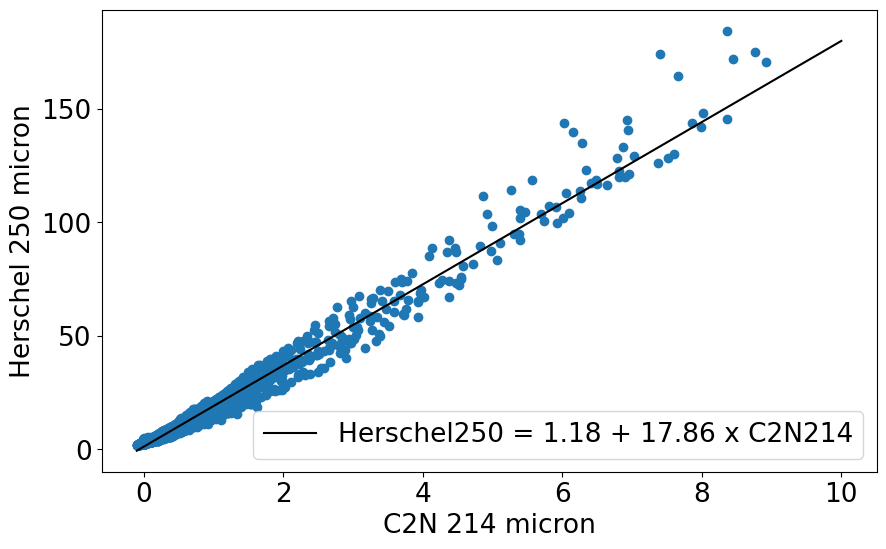

In [27]:
def lin_fit(x, a, b):
    return a + b*x

C2Ndata214 = MapStokesI.data.flatten()
Herschel250 = MapHer250.data.flatten()

C2Nbin = np.linspace(np.nanmin(C2Ndata214),10,100)

selector = ~np.isnan(C2Ndata214)
C2Ndata214_fil = C2Ndata214[selector]
Herschel250_fil = Herschel250[selector]

selector = ~np.isnan(Herschel250_fil)
C2Ndata214_fil = C2Ndata214_fil[selector]
Herschel250_fil = Herschel250_fil[selector]


# df_log = pd.DataFrame({'214':C2Ndata214,'250':Herschel250})
# df_log = df_log.dropna()

param, param_cov = curve_fit(lin_fit, C2Ndata214_fil, Herschel250_fil)
FitFunc = lin_fit(C2Nbin,param[0],param[1])

fig = plt.subplots(figsize =(10, 6))
ax = plt.subplot(111)
ax.scatter(C2Ndata214,Herschel250)
ax.plot(C2Nbin,FitFunc,'k',label = 'Herschel250 = {param_a:.2f} + {param_b:.2f} x C2N214'.format(param_a = param[0],param_b = param[1]))
ax.set_xlabel('C2N 214 micron')
ax.set_ylabel('Herschel 250 micron')
plt.legend()
plt.legend()
plt.show()

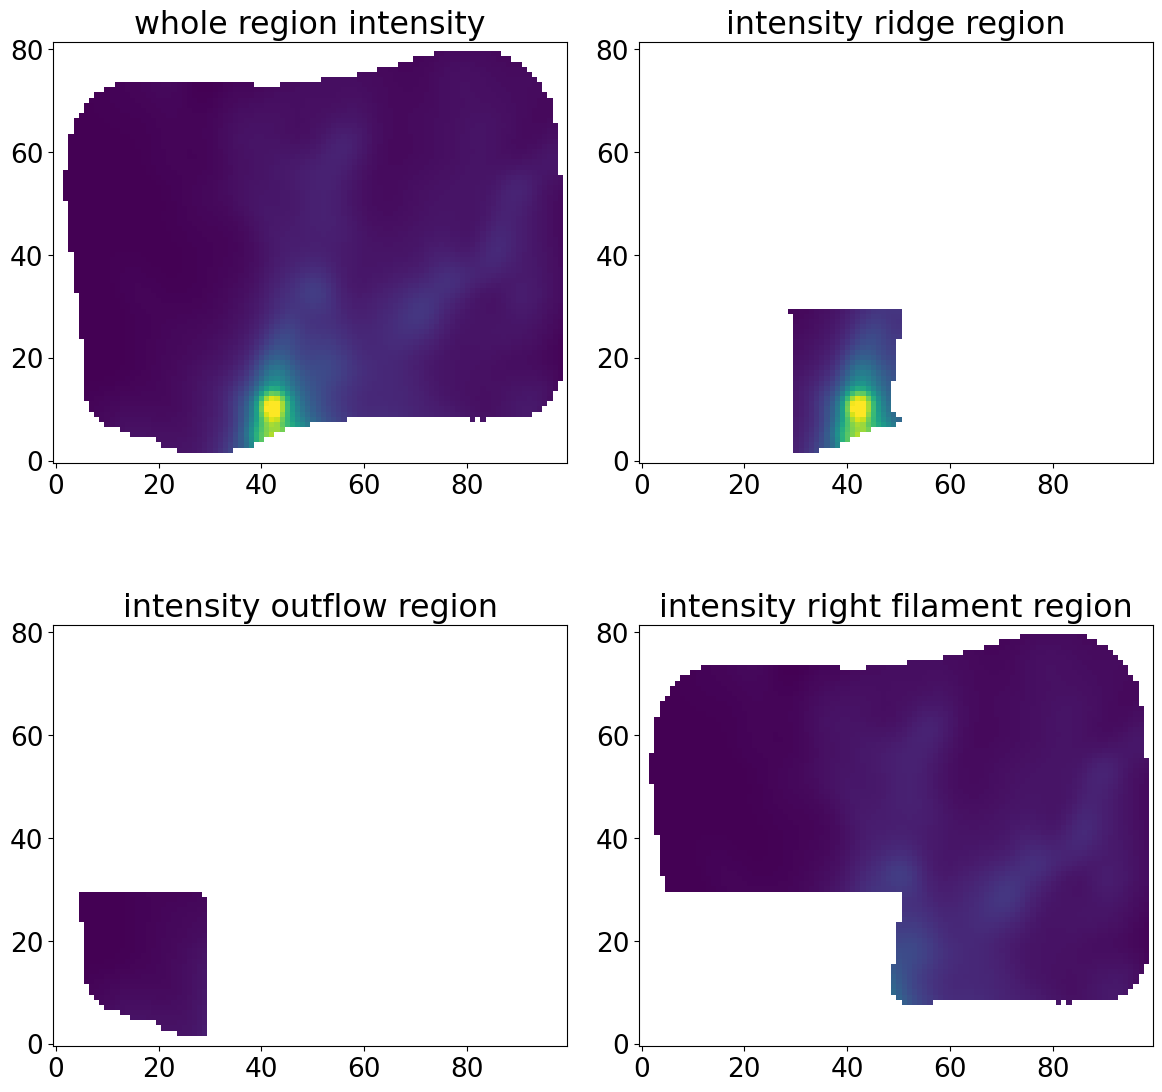

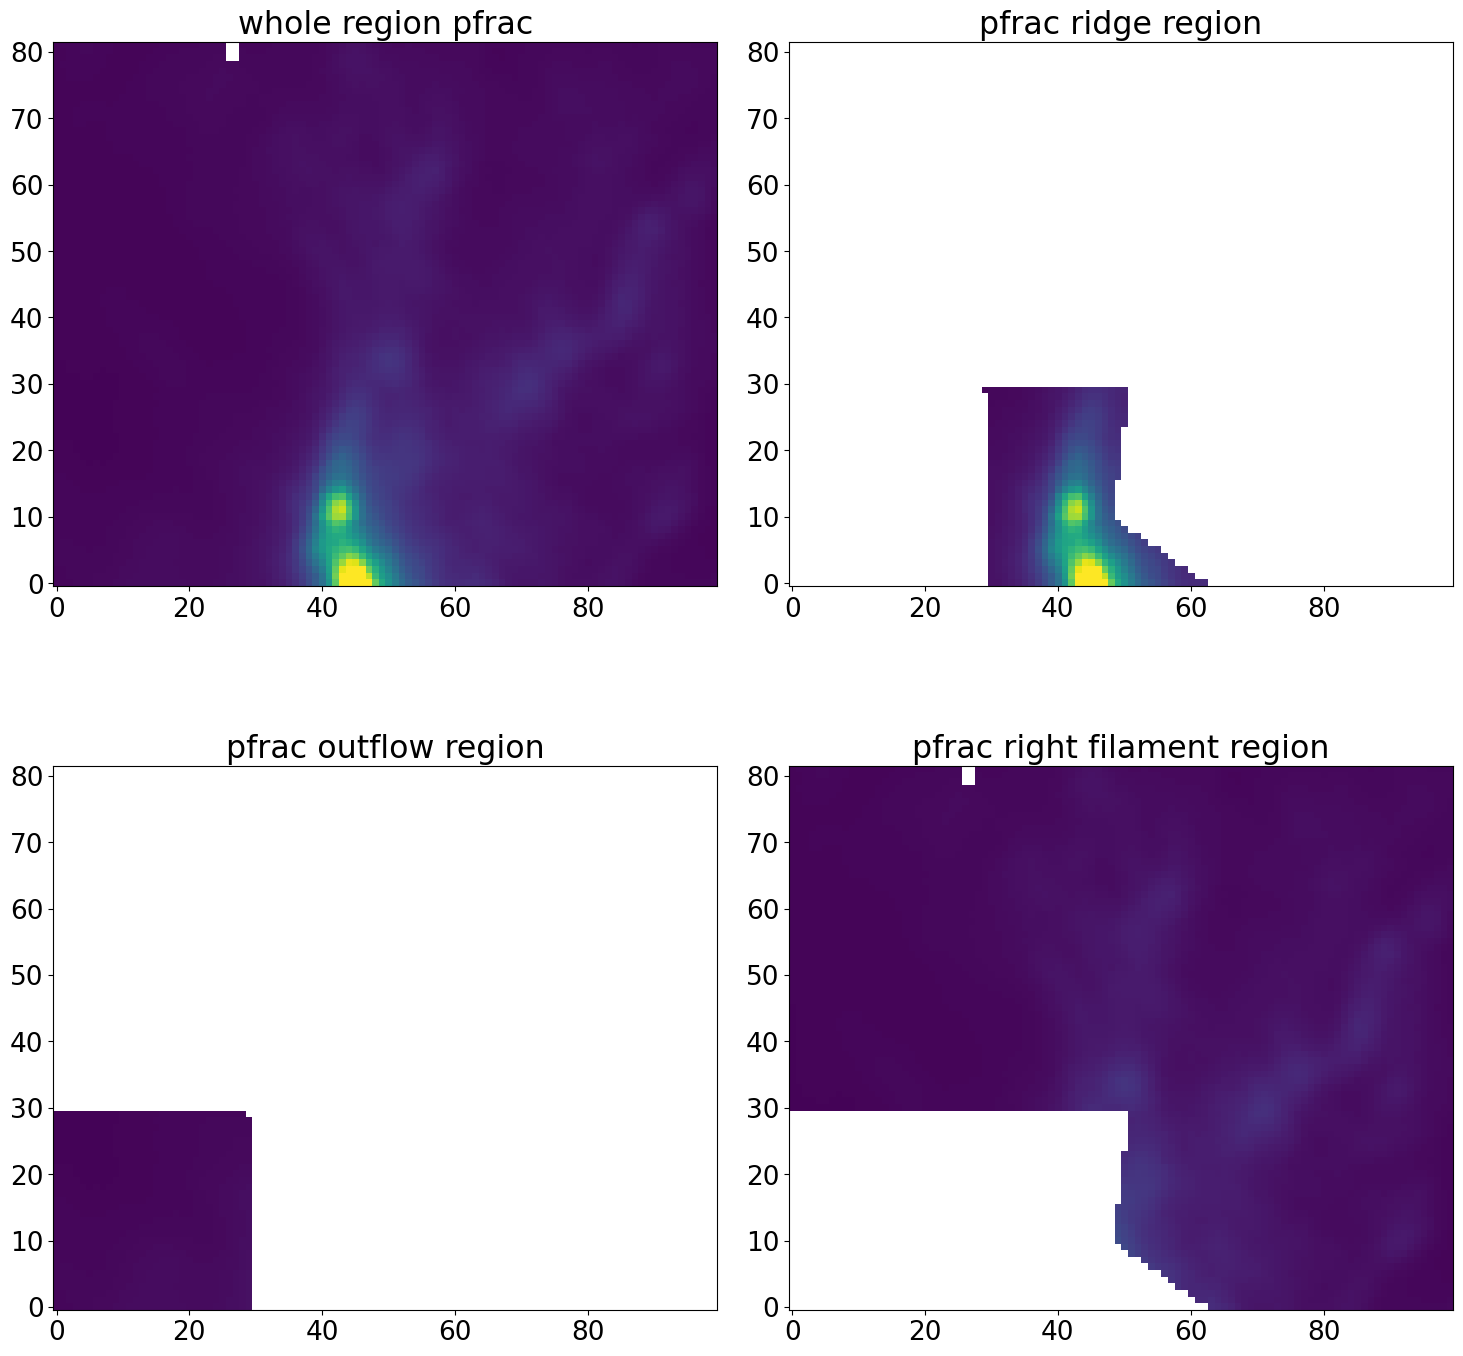

In [30]:
def line_1(x, y):
    top_x = 309.9258719
    top_y = 42.4556451
    bottom_x = 309.7452960
    bottom_y =   42.4556451
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_2(x, y):
    top_x = 309.7838598
    top_y = 42.4569364
    bottom_x = 309.7792727
    bottom_y =  42.3127837
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_3(x, y):
    top_x = 309.7468561
    top_y = 42.4529922
    bottom_x = 309.7507272
    bottom_y =  42.4299500
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_4(x, y):
    top_x = 309.7507272
    top_y = 42.4305231
    bottom_x = 309.7108001
    bottom_y =  42.4094674
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

def line_5(x, y):
    top_x = 309.7108001
    top_y = 42.4094674
    bottom_x = 309.699191
    bottom_y =  42.3710874
    slope = (top_y - bottom_y)/(top_x-bottom_x)
    return (y-top_y) - slope*(x-top_x)

C2N_ridge_plus_fill_right= MapStokesI.copy()
HER_ridge_plus_fill_right = MapHer250.copy()

C2N_outflow = MapStokesI.copy()
HER_outflow = MapHer250.copy()



selector = (line_1(RA_grid,DEC_grid)<0)*(line_2(RA_grid,DEC_grid)<0)
C2N_ridge_plus_fill_right.data[selector] = np.nan
HER_ridge_plus_fill_right.data[selector] = np.nan

selector = ~selector
C2N_outflow.data[selector] = np.nan
HER_outflow.data[selector] = np.nan



C2N_fil_right = C2N_ridge_plus_fill_right.copy()
HER_fil_right = HER_ridge_plus_fill_right.copy()


C2N_ridge = C2N_ridge_plus_fill_right.copy()
HER_ridge = HER_ridge_plus_fill_right.copy()



selector = (line_1(RA_grid,DEC_grid)>0)+ (line_3(RA_grid,DEC_grid)<0)*(line_4(RA_grid,DEC_grid)>0) + (line_5(RA_grid,DEC_grid)>0)
  
C2N_ridge.data[selector] = np.nan
HER_ridge.data[selector] = np.nan


selector = ~selector
C2N_fil_right.data[selector] = np.nan
HER_fil_right.data[selector] = np.nan


fig = plt.subplots(figsize =(12, 12))
ax1 = plt.subplot(221)
ax1.imshow(MapStokesI.data,origin='lower',vmin=0,vmax = 8)
ax1.set_title('whole region intensity')
ax2 = plt.subplot(222)
ax2.imshow(C2N_ridge.data,origin = 'lower',vmin=0,vmax = 8)
ax2.set_title('intensity ridge region')
ax3 = plt.subplot(223)
ax3.imshow(C2N_outflow.data,origin = 'lower',vmin=0,vmax = 8)
ax3.set_title('intensity outflow region')
ax4 = plt.subplot(224)
ax4.imshow(C2N_fil_right.data,origin = 'lower',vmin=0,vmax = 8)
ax4.set_title('intensity right filament region')
plt.tight_layout()
plt.show()

# fig = plt.subplots(figsize =(12, 12))
# ax1 = plt.subplot(111)
# ax1.imshow(np.log10(MapStokesI.data),origin='lower',vmin=0,vmax = 5)
# ax1.set_title('whole region intensity')
# fig = plt.subplots(figsize =(12, 12))
# ax2 = plt.subplot(111)
# ax2.imshow(np.log10(C2N_ridge.data),origin = 'lower',vmin=0,vmax = 5)
# ax2.set_title('intensity ridge region')
# fig = plt.subplots(figsize =(12, 12))
# ax3 = plt.subplot(111)
# ax3.imshow(np.log10(C2N_outflow.data),origin = 'lower',vmin=0,vmax = 5)
# ax3.set_title('intensity outflow region')
# fig = plt.subplots(figsize =(12, 12))
# ax4 = plt.subplot(111)
# ax4.imshow(np.log10(C2N_fil_right.data),origin = 'lower',vmin=0,vmax = 5)
# ax4.set_title('intensity right filament region')
# plt.tight_layout()
# plt.show()

fig = plt.subplots(figsize =(15, 15))
ax1 = plt.subplot(221)
ax1.imshow(MapHer250.data,origin='lower',vmin=0,vmax = 200)
ax1.set_title('whole region pfrac')
ax2 = plt.subplot(222)
ax2.imshow(HER_ridge.data,origin = 'lower',vmin=0,vmax = 200)
ax2.set_title('pfrac ridge region')
ax3 = plt.subplot(223)
ax3.imshow(HER_outflow.data,origin = 'lower',vmin=0,vmax = 200)
ax3.set_title('pfrac outflow region')
ax4 = plt.subplot(224)
ax4.imshow(HER_fil_right.data,origin = 'lower',vmin=0,vmax = 200)
ax4.set_title('pfrac right filament region')
plt.tight_layout()
plt.show()

# fig = plt.subplots(figsize =(12, 12))
# ax1 = plt.subplot(111)
# ax1.imshow(MapHer250.data,origin='lower',vmin=0,vmax = 50)
# ax1.set_title('whole region Her250')
# fig = plt.subplots(figsize =(12, 12))
# ax2 = plt.subplot(111)
# ax2.imshow(HER_ridge.data,origin = 'lower',vmin=0,vmax = 5)
# ax2.set_title('pfrac ridge region')
# fig = plt.subplots(figsize =(12, 12))
# ax3 = plt.subplot(111)
# ax3.imshow(HER_outflow.data,origin = 'lower',vmin=0,vmax = 5)
# ax3.set_title('pfrac outflow region')
# fig = plt.subplots(figsize =(12, 12))
# ax4 = plt.subplot(111)
# ax4.imshow(HER_fil_right.data,origin = 'lower',vmin=0,vmax = 5)
# ax4.set_title('pfrac right filament region')
# plt.tight_layout()
# plt.show()



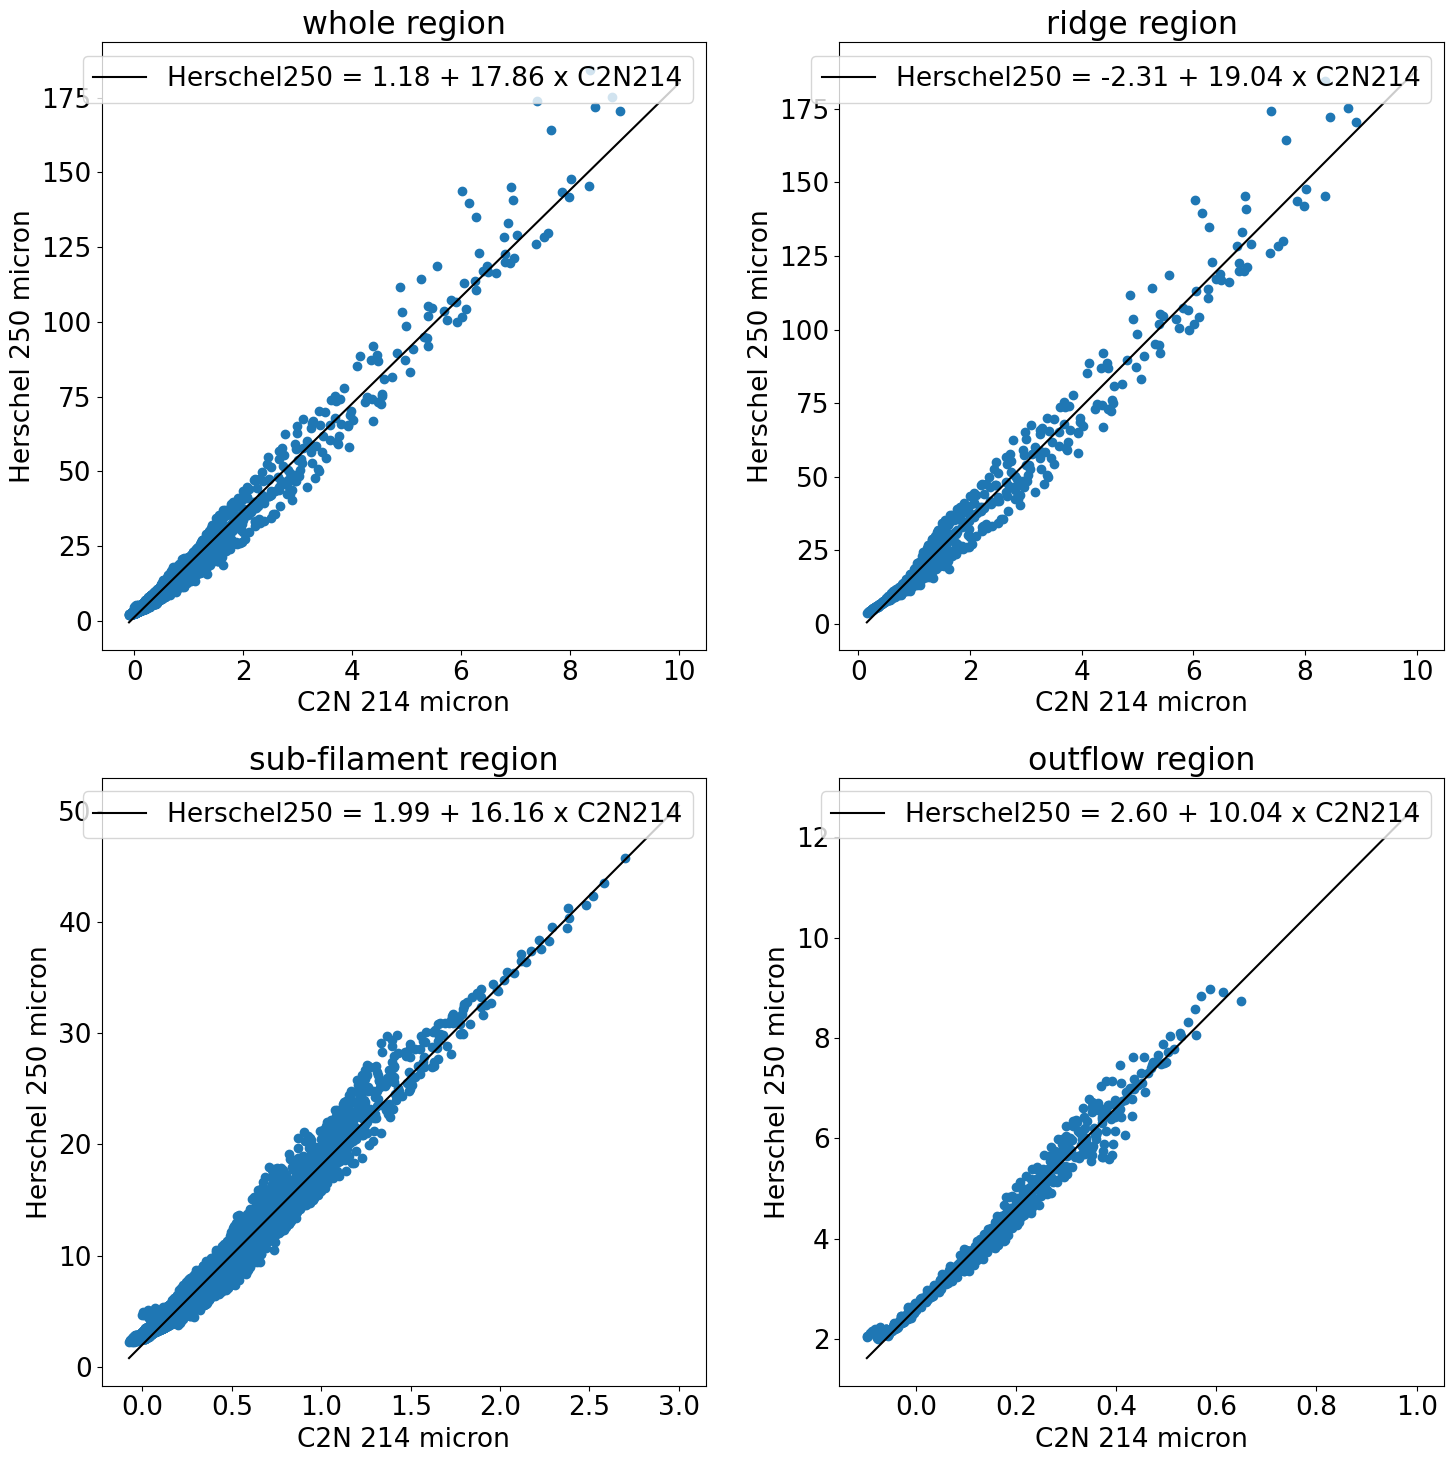

In [33]:
def remove_nan(array1,array2):
    selector = ~np.isnan(array1)
    array1_fil = array1[selector]
    array2_fil = array2[selector]

    selector = ~np.isnan(array2_fil)
    array1_fil = array1_fil[selector]
    array2_fil = array2_fil[selector]
    return array1_fil,array2_fil



C2Ndata215 = MapStokesI.data.flatten()
C2N_ridge_array = C2N_ridge.data.flatten()
C2N_outflow_array = C2N_outflow.data.flatten() 
C2N_fil_right_array =C2N_fil_right.data.flatten()

Herschel250 = MapHer250.data.flatten()
HER_ridge_array = HER_ridge.data.flatten()
HER_outflow_aray = HER_outflow.data.flatten()
HER_fil_right_array=HER_fil_right.data.flatten()




# selector = ~np.isnan(C2Ndata214)
# C2Ndata214_fil = C2Ndata214[selector]
# Herschel250_fil = Herschel250[selector]

# selector = ~np.isnan(Herschel250_fil)
# C2Ndata214_fil = C2Ndata214_fil[selector]
# Herschel250_fil = Herschel250_fil[selector]

C2Ndata214_fil,Herschel250_fil = remove_nan(C2Ndata215,Herschel250)
w_param, w_param_cov = curve_fit(lin_fit, C2Ndata214_fil, Herschel250_fil)
w_bin = np.linspace(np.nanmin(C2Ndata214),10,100)
w_FitFunc = lin_fit(w_bin,w_param[0],w_param[1])

C2N_ridge_array_fil,HER_ridge_array_fil = remove_nan(C2N_ridge_array,HER_ridge_array)
r_param, r_param_cov = curve_fit(lin_fit, C2N_ridge_array_fil, HER_ridge_array_fil)
r_bin = np.linspace(np.nanmin(C2N_ridge_array_fil),10,100)
r_FitFunc = lin_fit(r_bin,r_param[0],r_param[1])

C2N_outflow_array_fil,HER_outflow_aray_fil = remove_nan(C2N_outflow_array,HER_outflow_aray)
o_param, o_param_cov = curve_fit(lin_fit, C2N_outflow_array_fil, HER_outflow_aray_fil)
o_bin = np.linspace(np.nanmin(C2N_outflow_array_fil),1,100)
o_FitFunc = lin_fit(o_bin,o_param[0],o_param[1])

C2N_fil_right_array_fil,HER_fil_right_array_fil = remove_nan(C2N_fil_right_array,HER_fil_right_array)
s_param, s_param_cov = curve_fit(lin_fit, C2N_fil_right_array_fil, HER_fil_right_array_fil)
s_bin = np.linspace(np.nanmin(C2N_fil_right_array_fil),3,100)
s_FitFunc = lin_fit(s_bin,s_param[0],s_param[1])




fig = plt.subplots(figsize =(15, 15))
ax1 = plt.subplot(221)
ax1.scatter(C2Ndata215,Herschel250)
ax1.plot(w_bin,w_FitFunc,'k',label = 'Herschel250 = {param_a:.2f} + {param_b:.2f} x C2N214'.format(param_a = w_param[0],param_b = w_param[1]))
ax1.set_xlabel('C2N 214 micron')
ax1.set_ylabel('Herschel 250 micron')
ax1.set_title('whole region')
ax1.legend()

ax2 = plt.subplot(222)
ax2.scatter(C2N_ridge_array,HER_ridge_array)
ax2.plot(r_bin,r_FitFunc,'k',label = 'Herschel250 = {param_a:.2f} + {param_b:.2f} x C2N214'.format(param_a = r_param[0],param_b = r_param[1]))
ax2.set_xlabel('C2N 214 micron')
ax2.set_ylabel('Herschel 250 micron')
ax2.set_title('ridge region')
ax2.legend()

ax3 = plt.subplot(223)
ax3.scatter(C2N_fil_right_array,HER_fil_right_array)
ax3.plot(s_bin,s_FitFunc,'k',label = 'Herschel250 = {param_a:.2f} + {param_b:.2f} x C2N214'.format(param_a = s_param[0],param_b = s_param[1]))
ax3.set_xlabel('C2N 214 micron')
ax3.set_ylabel('Herschel 250 micron')
ax3.set_title('sub-filament region')
ax3.legend()

ax4 = plt.subplot(224)
ax4.scatter(C2N_outflow_array,HER_outflow_aray)
ax4.plot(o_bin,o_FitFunc,'k',label = 'Herschel250 = {param_a:.2f} + {param_b:.2f} x C2N214'.format(param_a = o_param[0],param_b = o_param[1]))
ax4.set_xlabel('C2N 214 micron')
ax4.set_ylabel('Herschel 250 micron')
ax4.set_title('outflow region')
ax4.legend()
plt.tight_layout()
plt.show()